In [6]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021" # <-- change the path to your code directory
sys.path.append("../bda_models")
sys.path.append(CODE_DIR)

import os
import torch
import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *

## Paths for saving / loading

In [15]:
SAVE_DIR = "output_files"
os.makedirs(SAVE_DIR, exist_ok=True)

# PTB - Topics
TOPIC_MODEL_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/topic_model_surprisal_values.pt"
TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/topic_model_surprisal_dp_mixtures.p"

# PTB - Sequence length
SEQUENCE_LEN_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/sequence_len_surprisal_values.pt"
SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/sequence_length_surprisal_dp_mixtures.pt"

# MNIST
MNIST_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/MNIST_surprisal_values.pt"
MNIST_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/MNIST_surprisal_dp_mixtures.pt"

## DP globals

In [16]:
MAX_SAMPLES_PER_GROUP = 300
NUM_COMPS = 5
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 1200

# Load overview of the experiments & global evaluation stats to plot against

In [20]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

overview_df.head()

objective  l_rate dataset  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T        INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++   INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T       INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++  INFO-VAE     0.1  bmnist   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T      INFO-VAE     0.1  bmnist   

                                             image_or_language  beta_beta  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T                   image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++              image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T                  image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++             image        0.0   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T                 image        0.0   

                                              free_bits  mdr_value  l_mmd  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T                0          0      1   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++           0          0      1   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T               0          0     10   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++          0          0     10   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T              0          0    100   

                                                           decoder  \
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T        basic_deconv_decoder   
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++      cond_pixel_cnn_pp   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T       basic_deconv_decoder   
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++     cond_pixel_cnn_pp   
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T      basic_deconv_decoder   

                                                                                       run_name  
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T        (inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2...  
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++   (inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2...  
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T       (20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd...  
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++  (20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd...  
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T      (inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2...

# PTB - Topics

## Load surprisal values

In [14]:
if os.path.exists(TOPIC_MODEL_SAVE_BDA_SURPRISAL_VALS_FILE):
    topic_model_surprisal_values = torch.load(TOPIC_MODEL_SAVE_BDA_SURPRISAL_VALS_FILE)
else:
    print(f"Surprisal values not found in {TOPIC_MODEL_SAVE_BDA_SURPRISAL_VALS_FILE}")

## Plot surprisal values

Rows: 22, cols: 3, every: 1, n_groups: 22


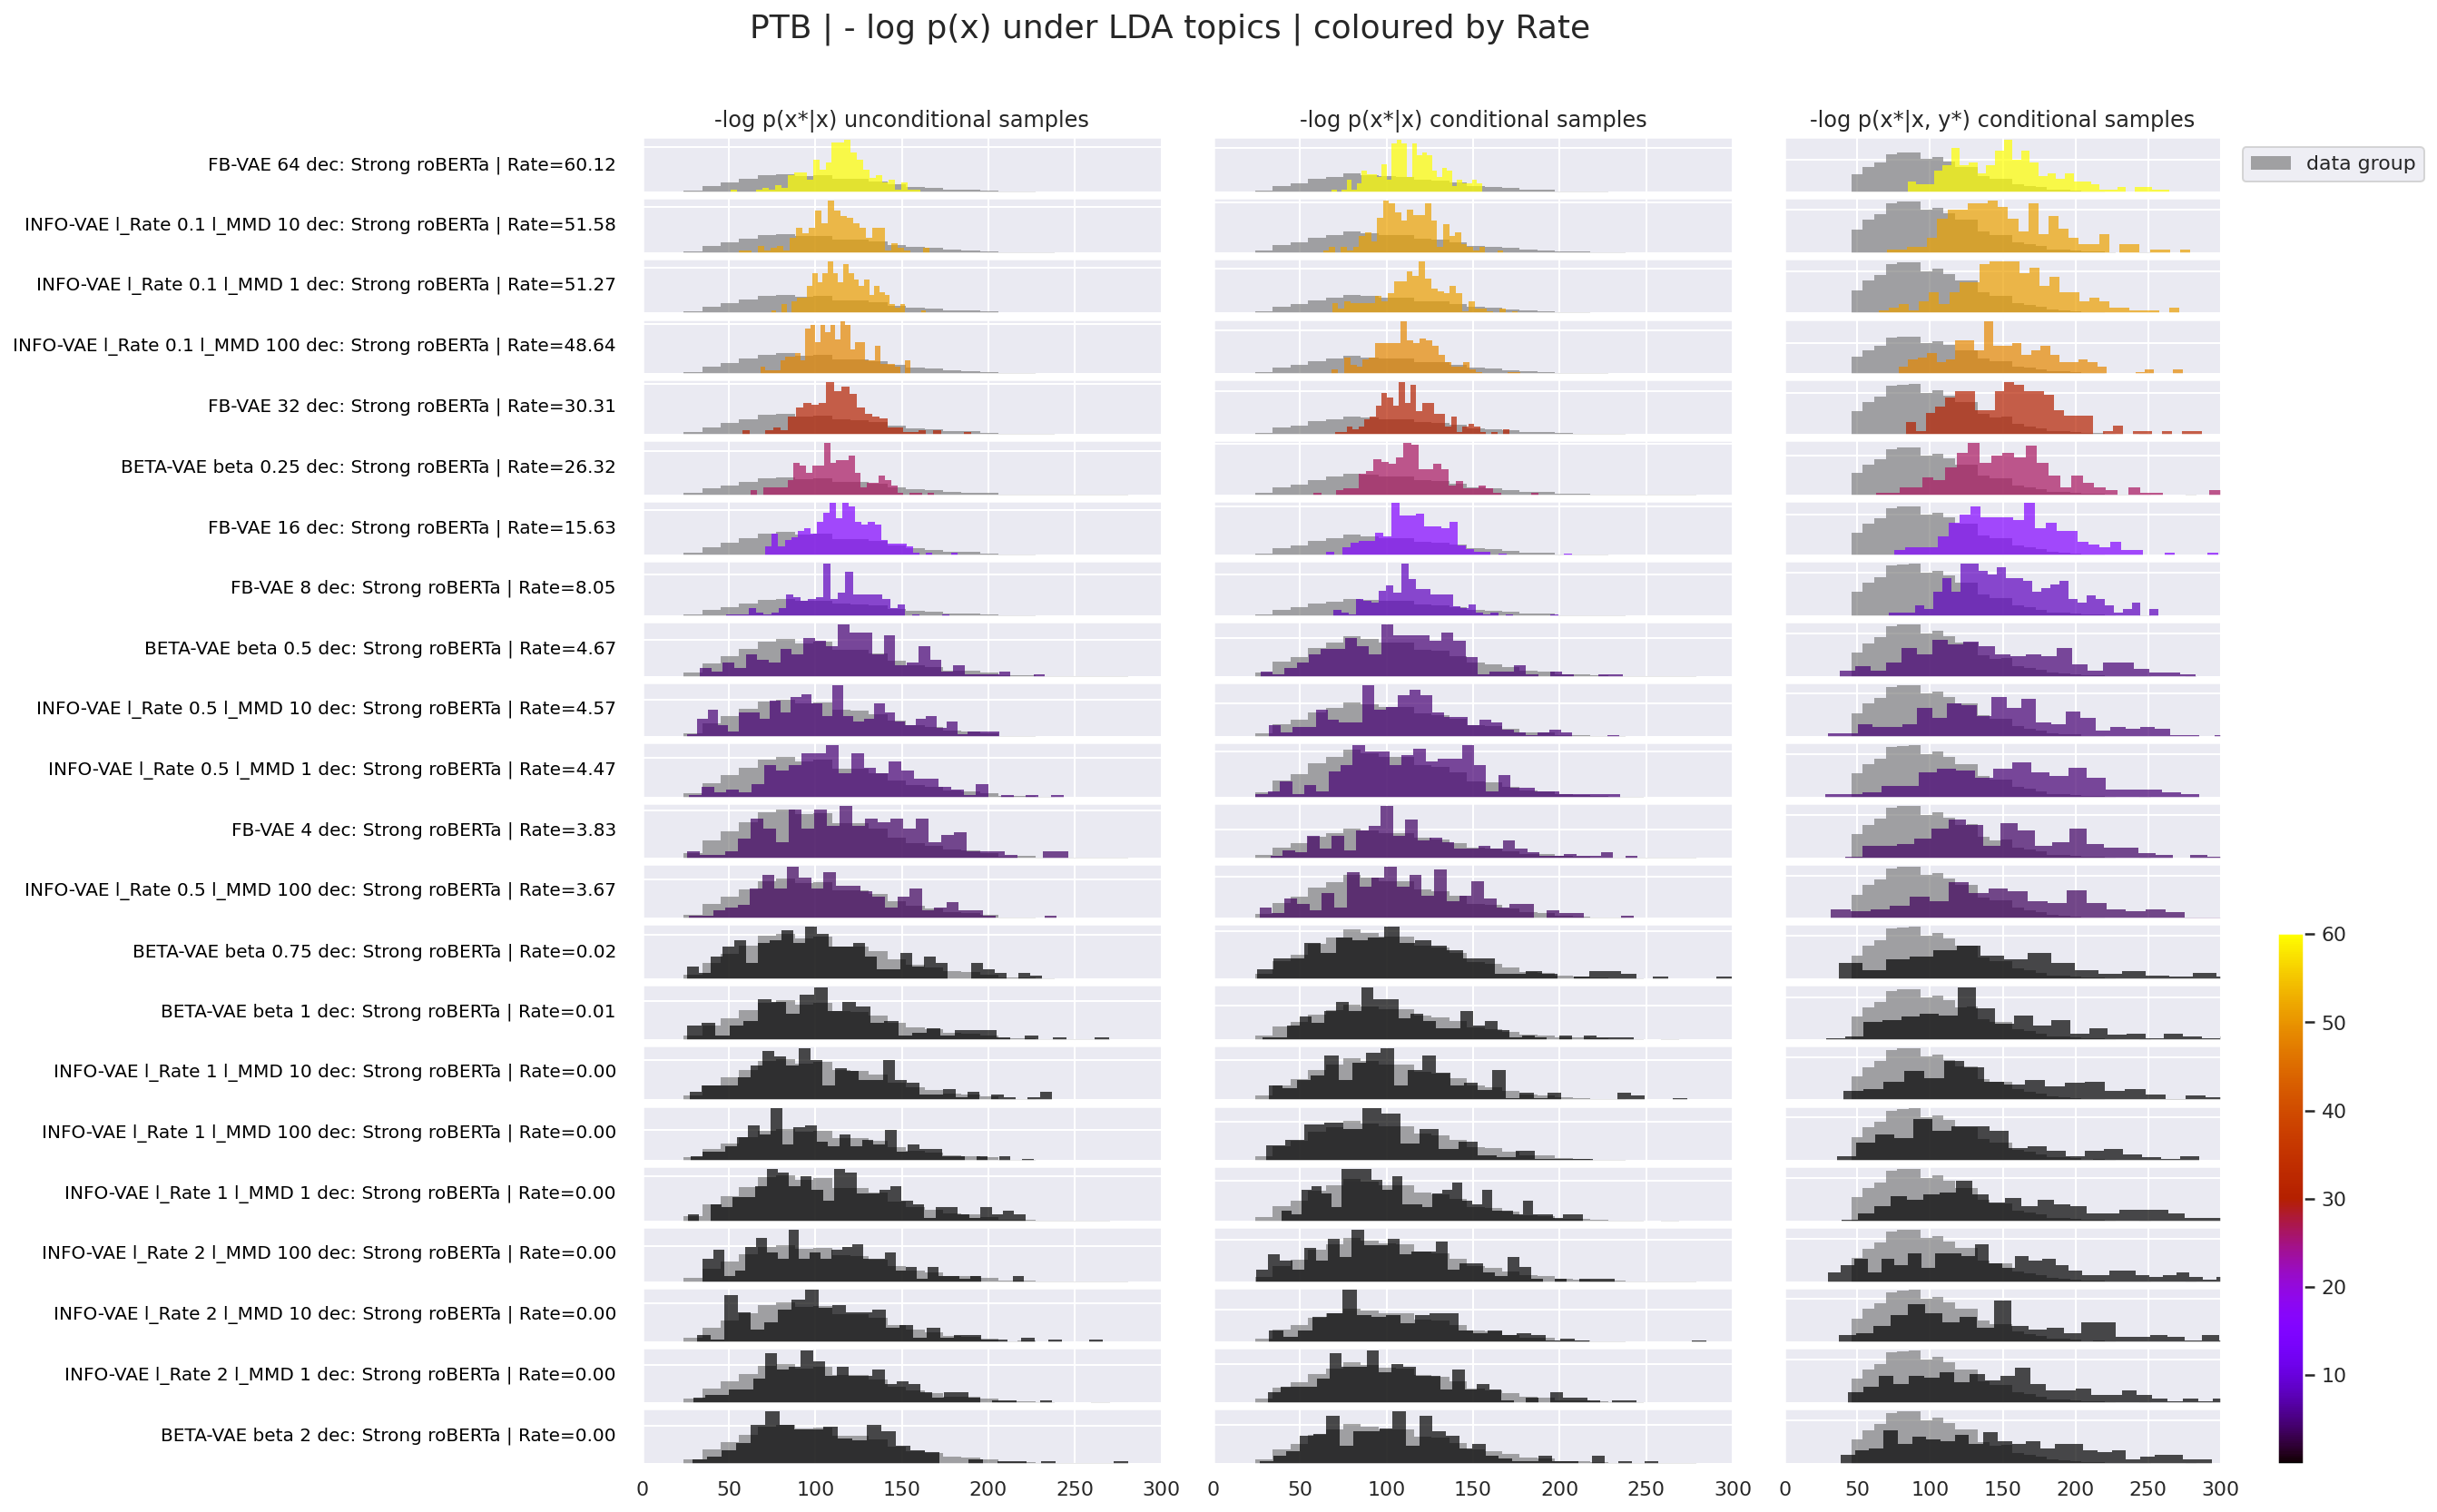

In [15]:
xlims = [[0, 300], [0, 300], [0, 300]]
ylims = [None, None, None]

# Filter out high rate model for visualisation purposes and load the PTB (language) experiments only
global_stats_df_filter = global_stats_df[(global_stats_df["kl_prior_post"] < 70) \
                                         & ((global_stats_df["image_or_language"] == "language"))]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=topic_model_surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="LDA topics",
                                         sort_name="Rate", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.05,
                                         subsample_nrows=None, 
                                         sort_ascend=False, 
                                         row_height=0.5)

## Fit 3 DP Mixtures on 3 types of surprisal values

1. unconditional_unconditional: unconditional surprisal statistic on unconditional samples
2. unconditional_unconditional: unconditional surprisal statistic on conditional samples
3. unconditional_unconditional: conditional surprisal statistic on conditional samples

STAT: unconditional_unconditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
Warning, values higher than 1000.0, filtering those out.


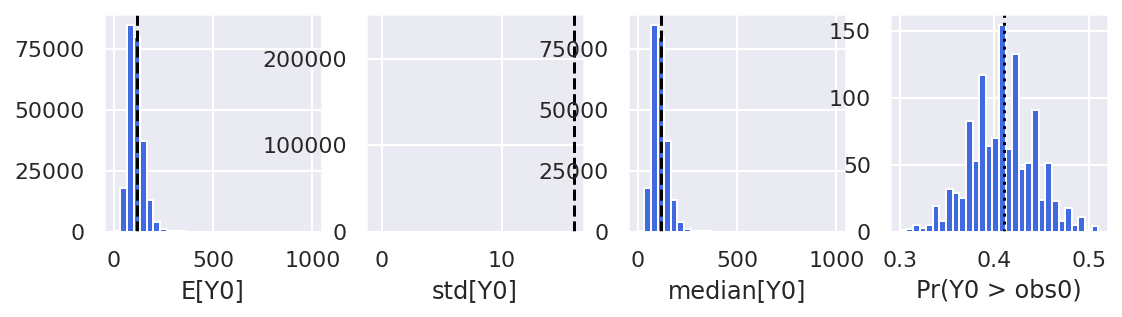

Warning, values higher than 1000.0, filtering those out.


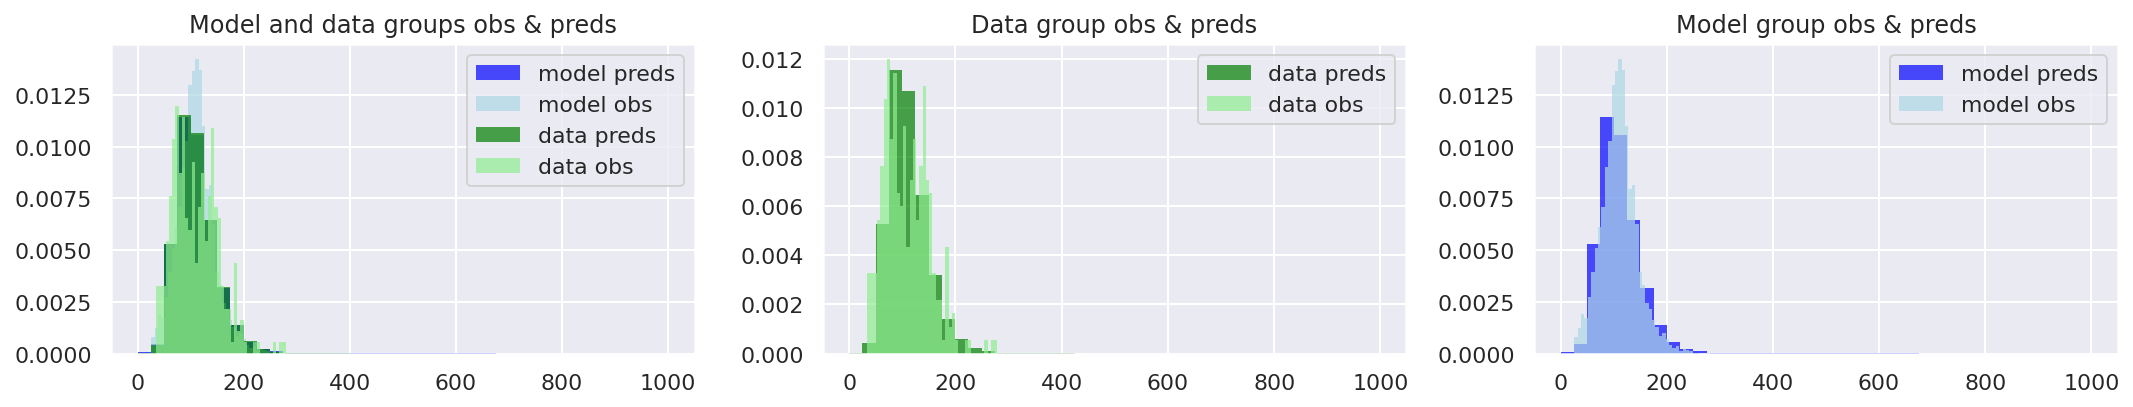

Warning, values higher than 1000.0, filtering those out


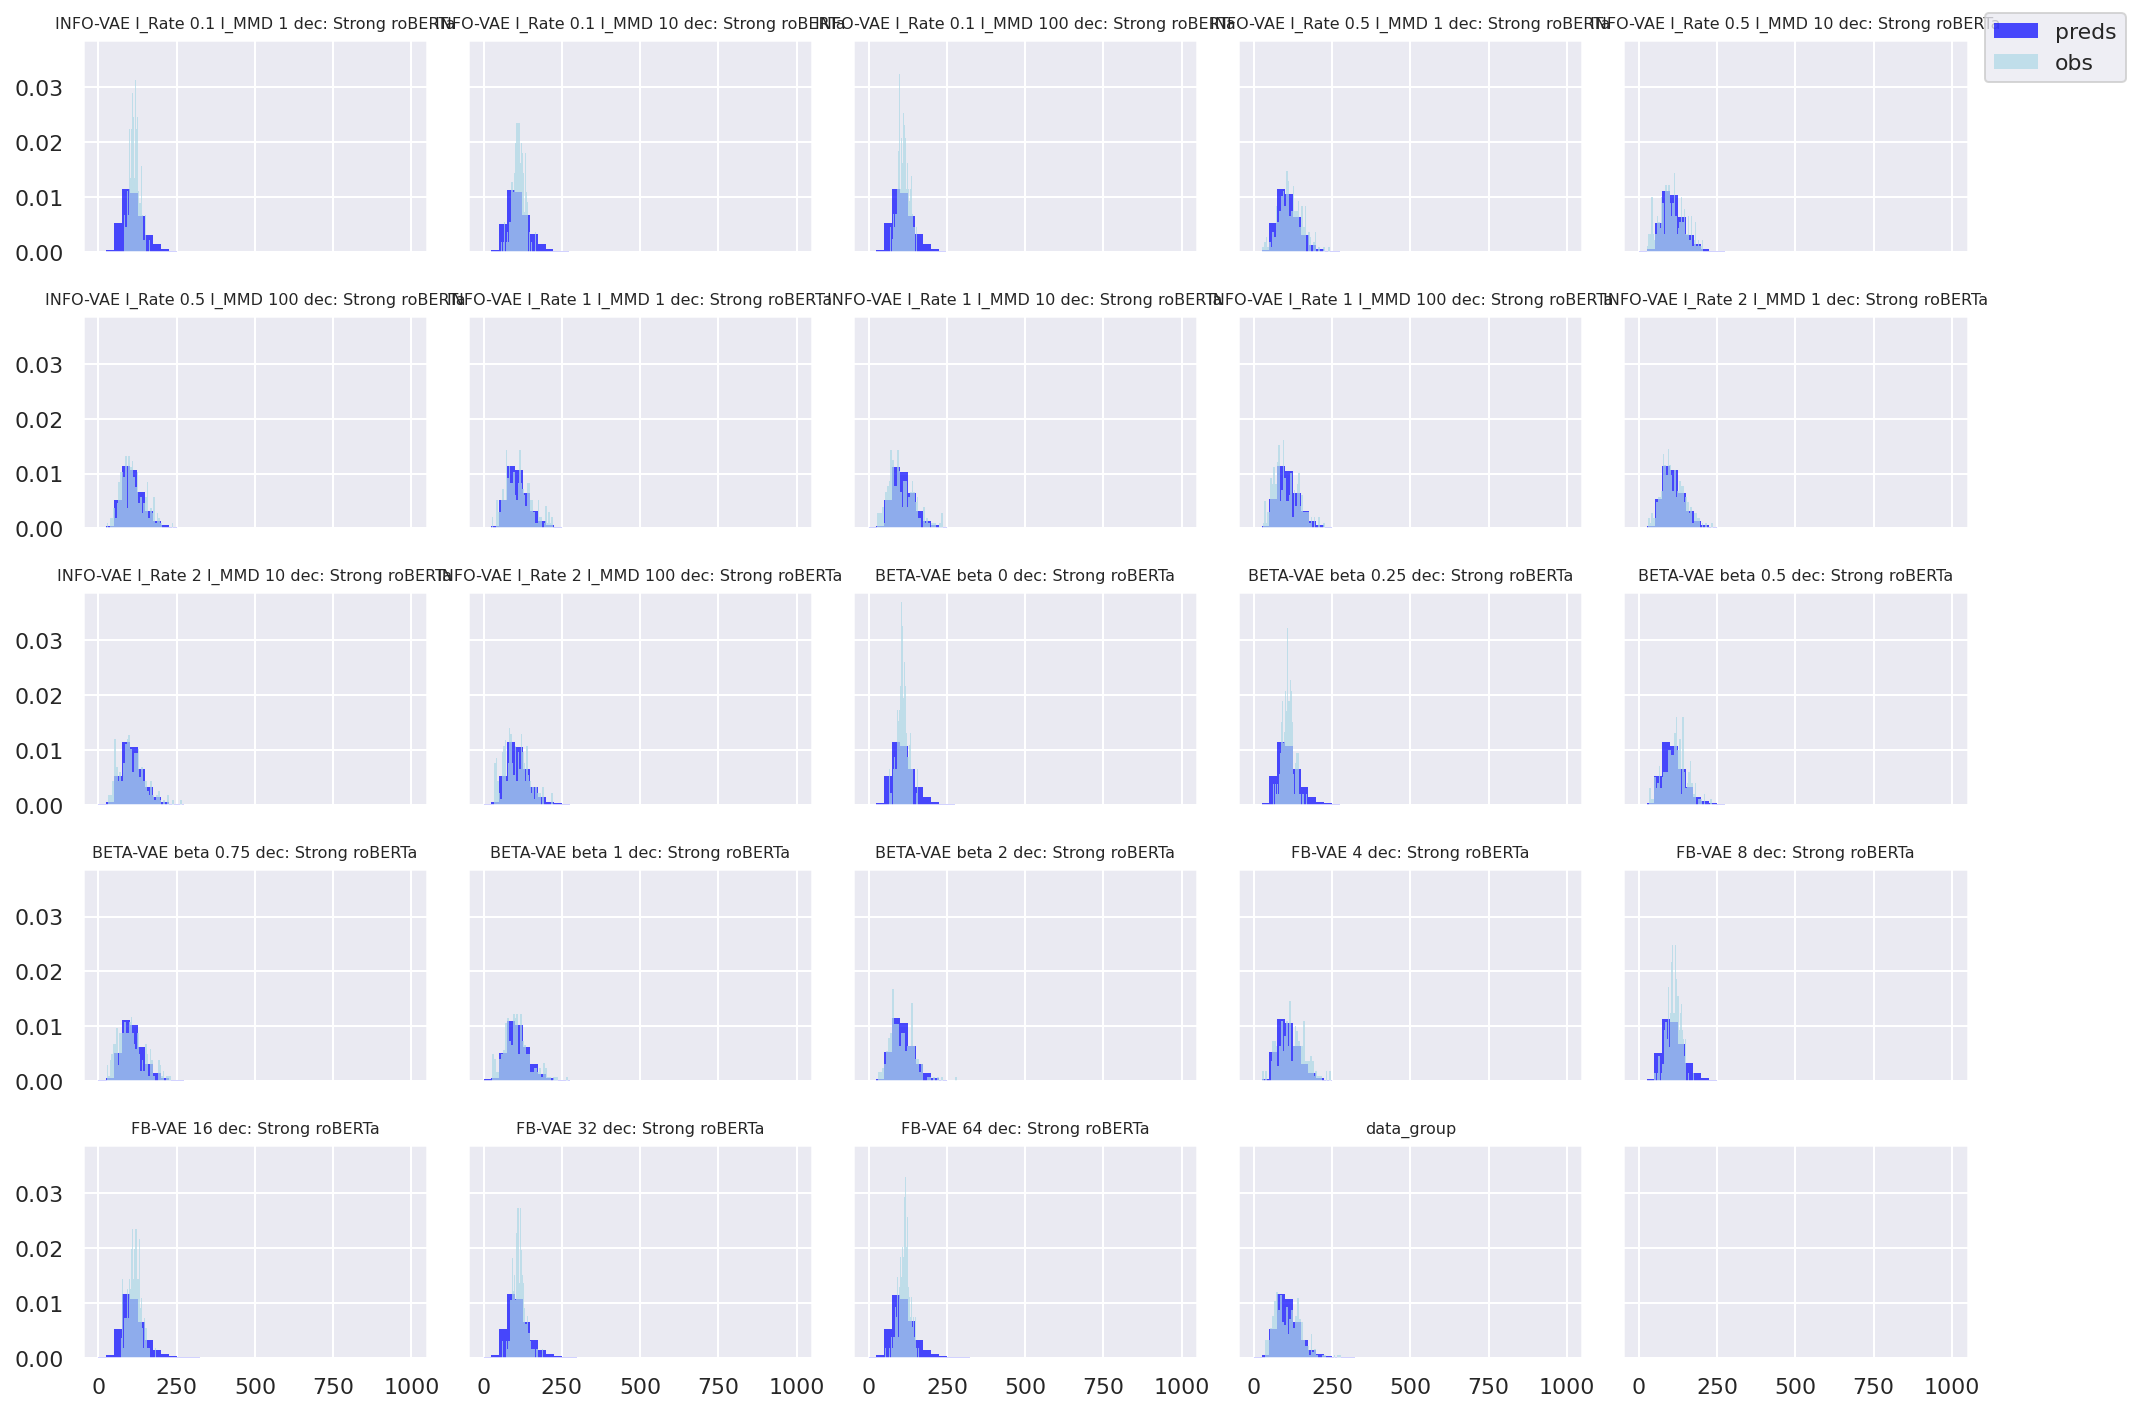

----------------------------------------
STAT: unconditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
Warning, values higher than 1000.0, filtering those out.


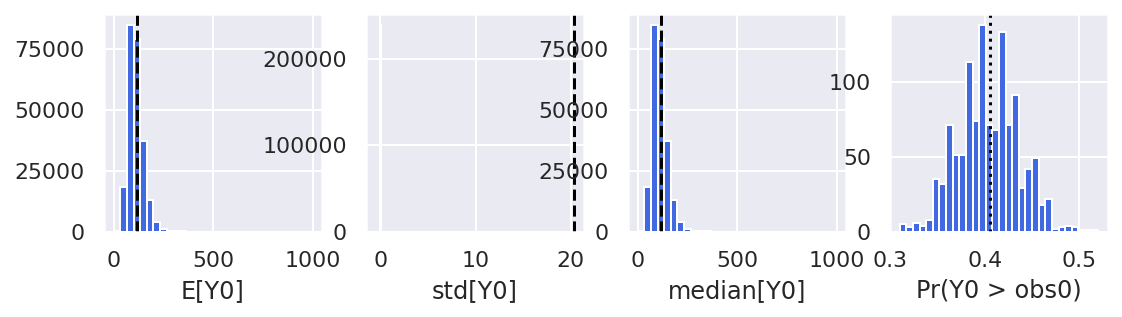

Warning, values higher than 1000.0, filtering those out.


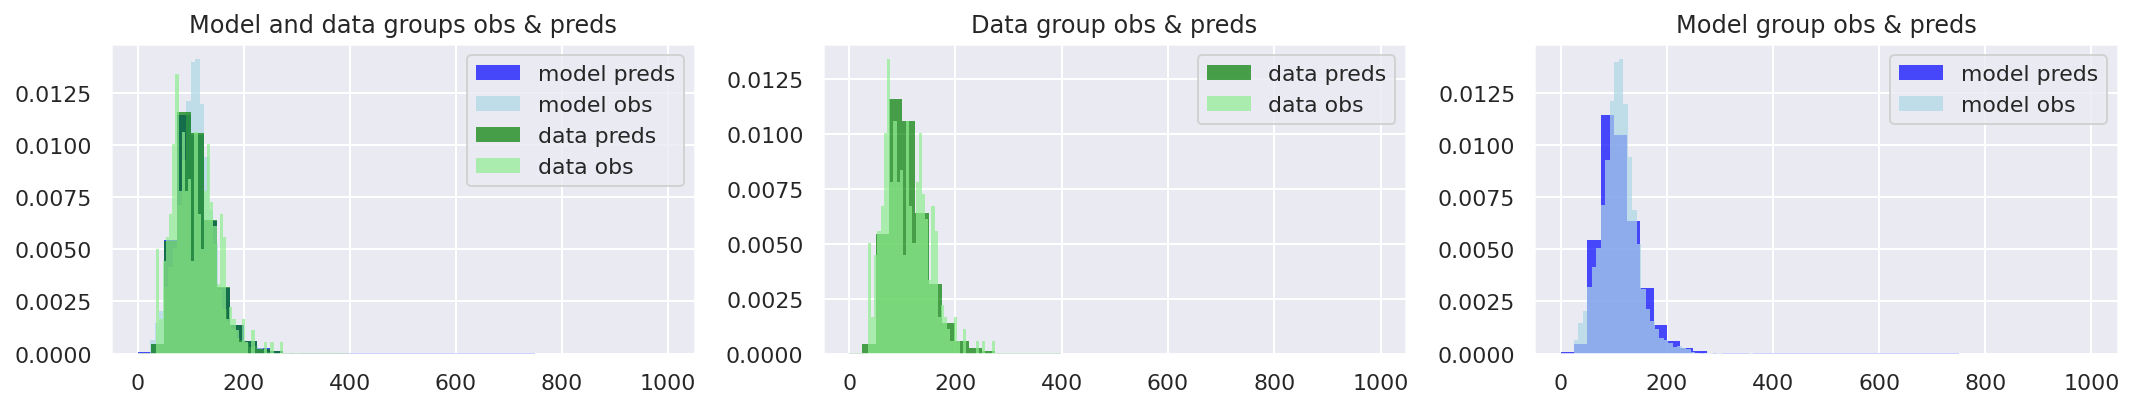

Warning, values higher than 1000.0, filtering those out


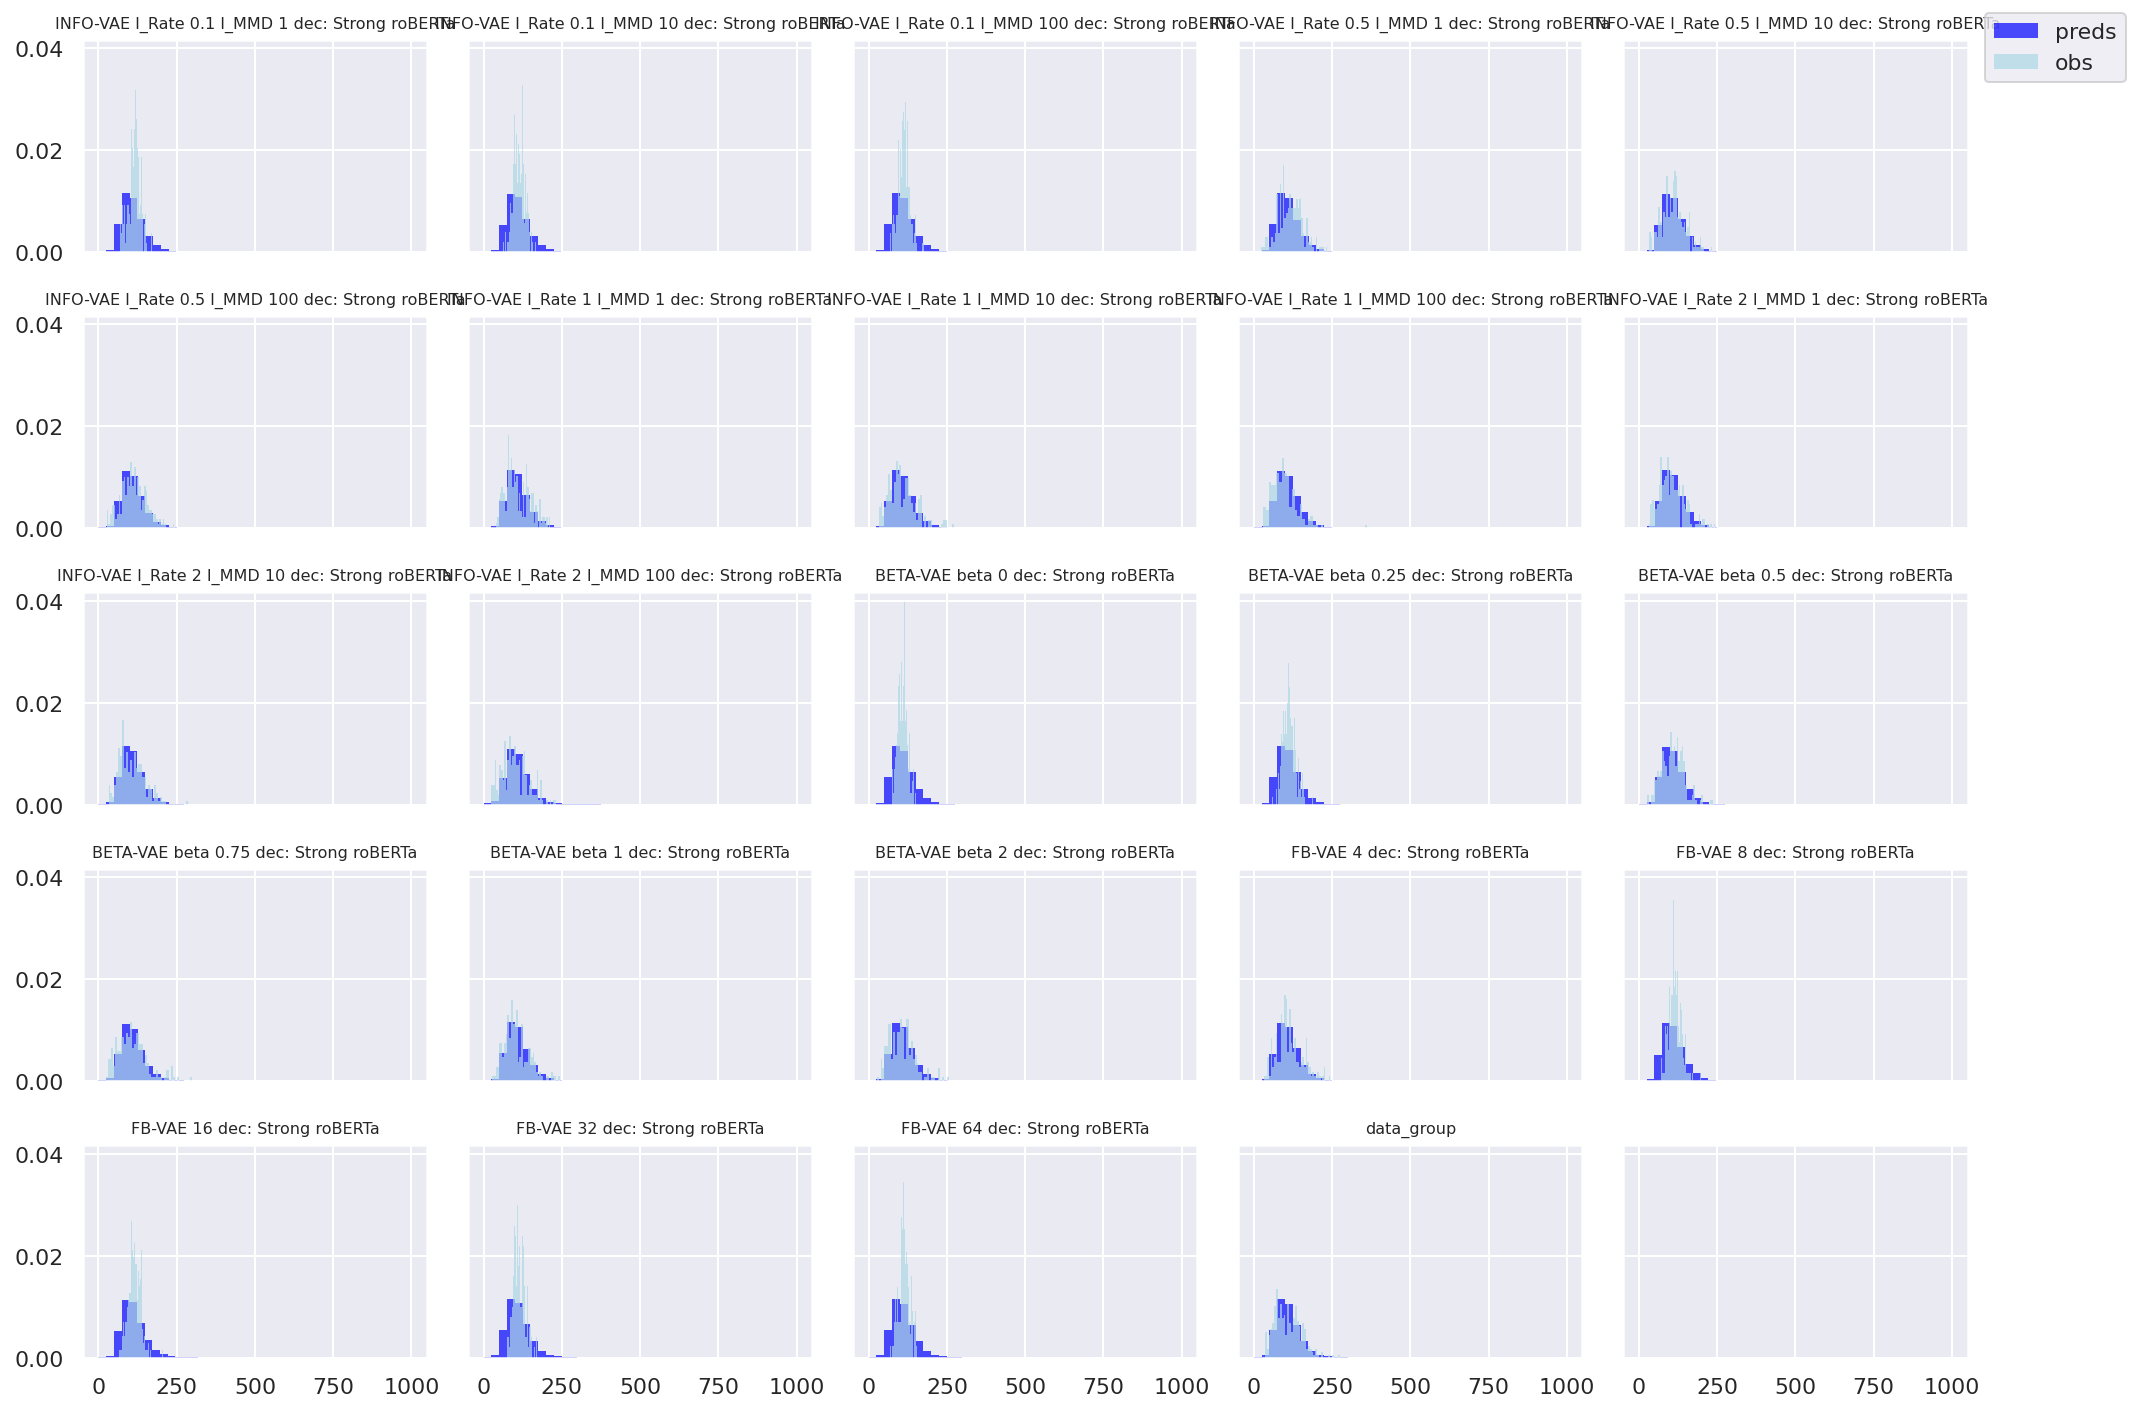

----------------------------------------
STAT: conditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
Warning, values higher than 1000.0, filtering those out.


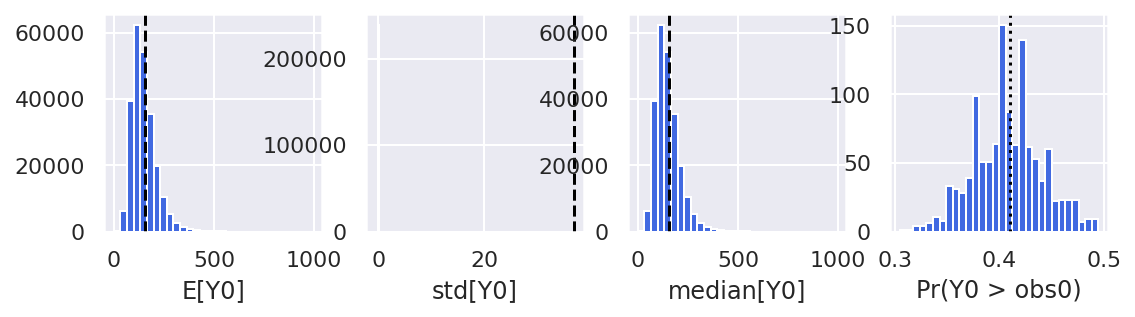

Warning, values higher than 1000.0, filtering those out.


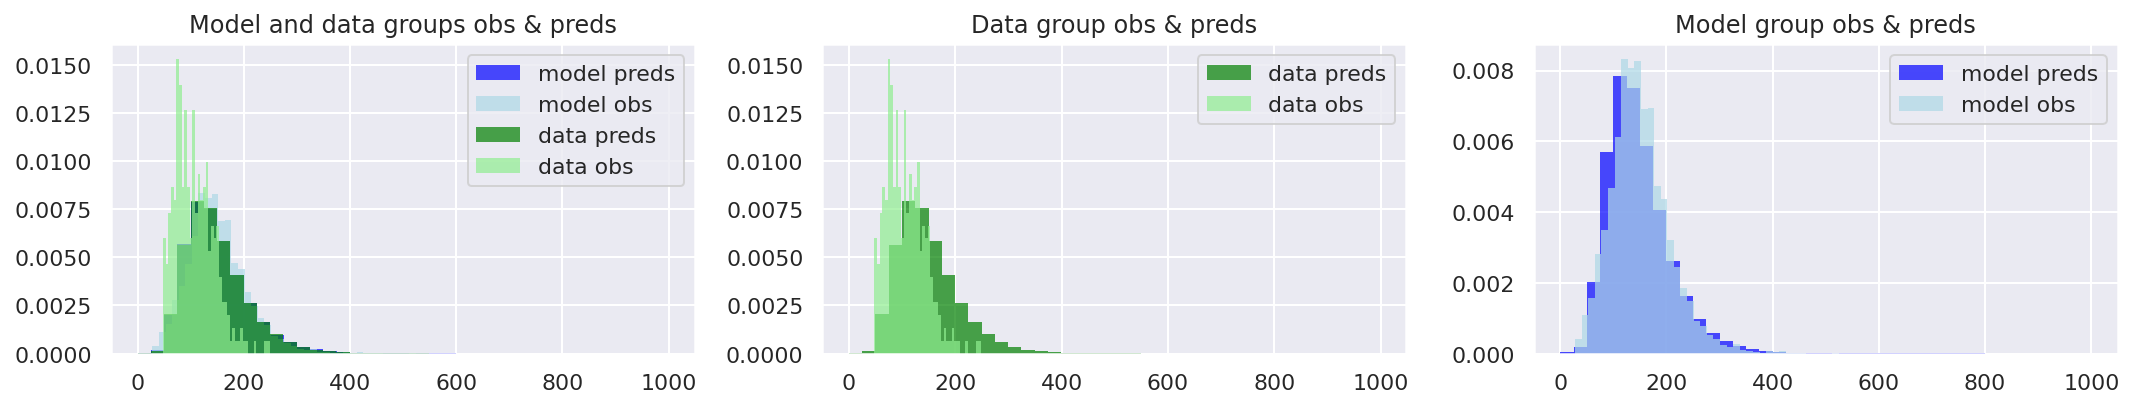

Warning, values higher than 1000.0, filtering those out


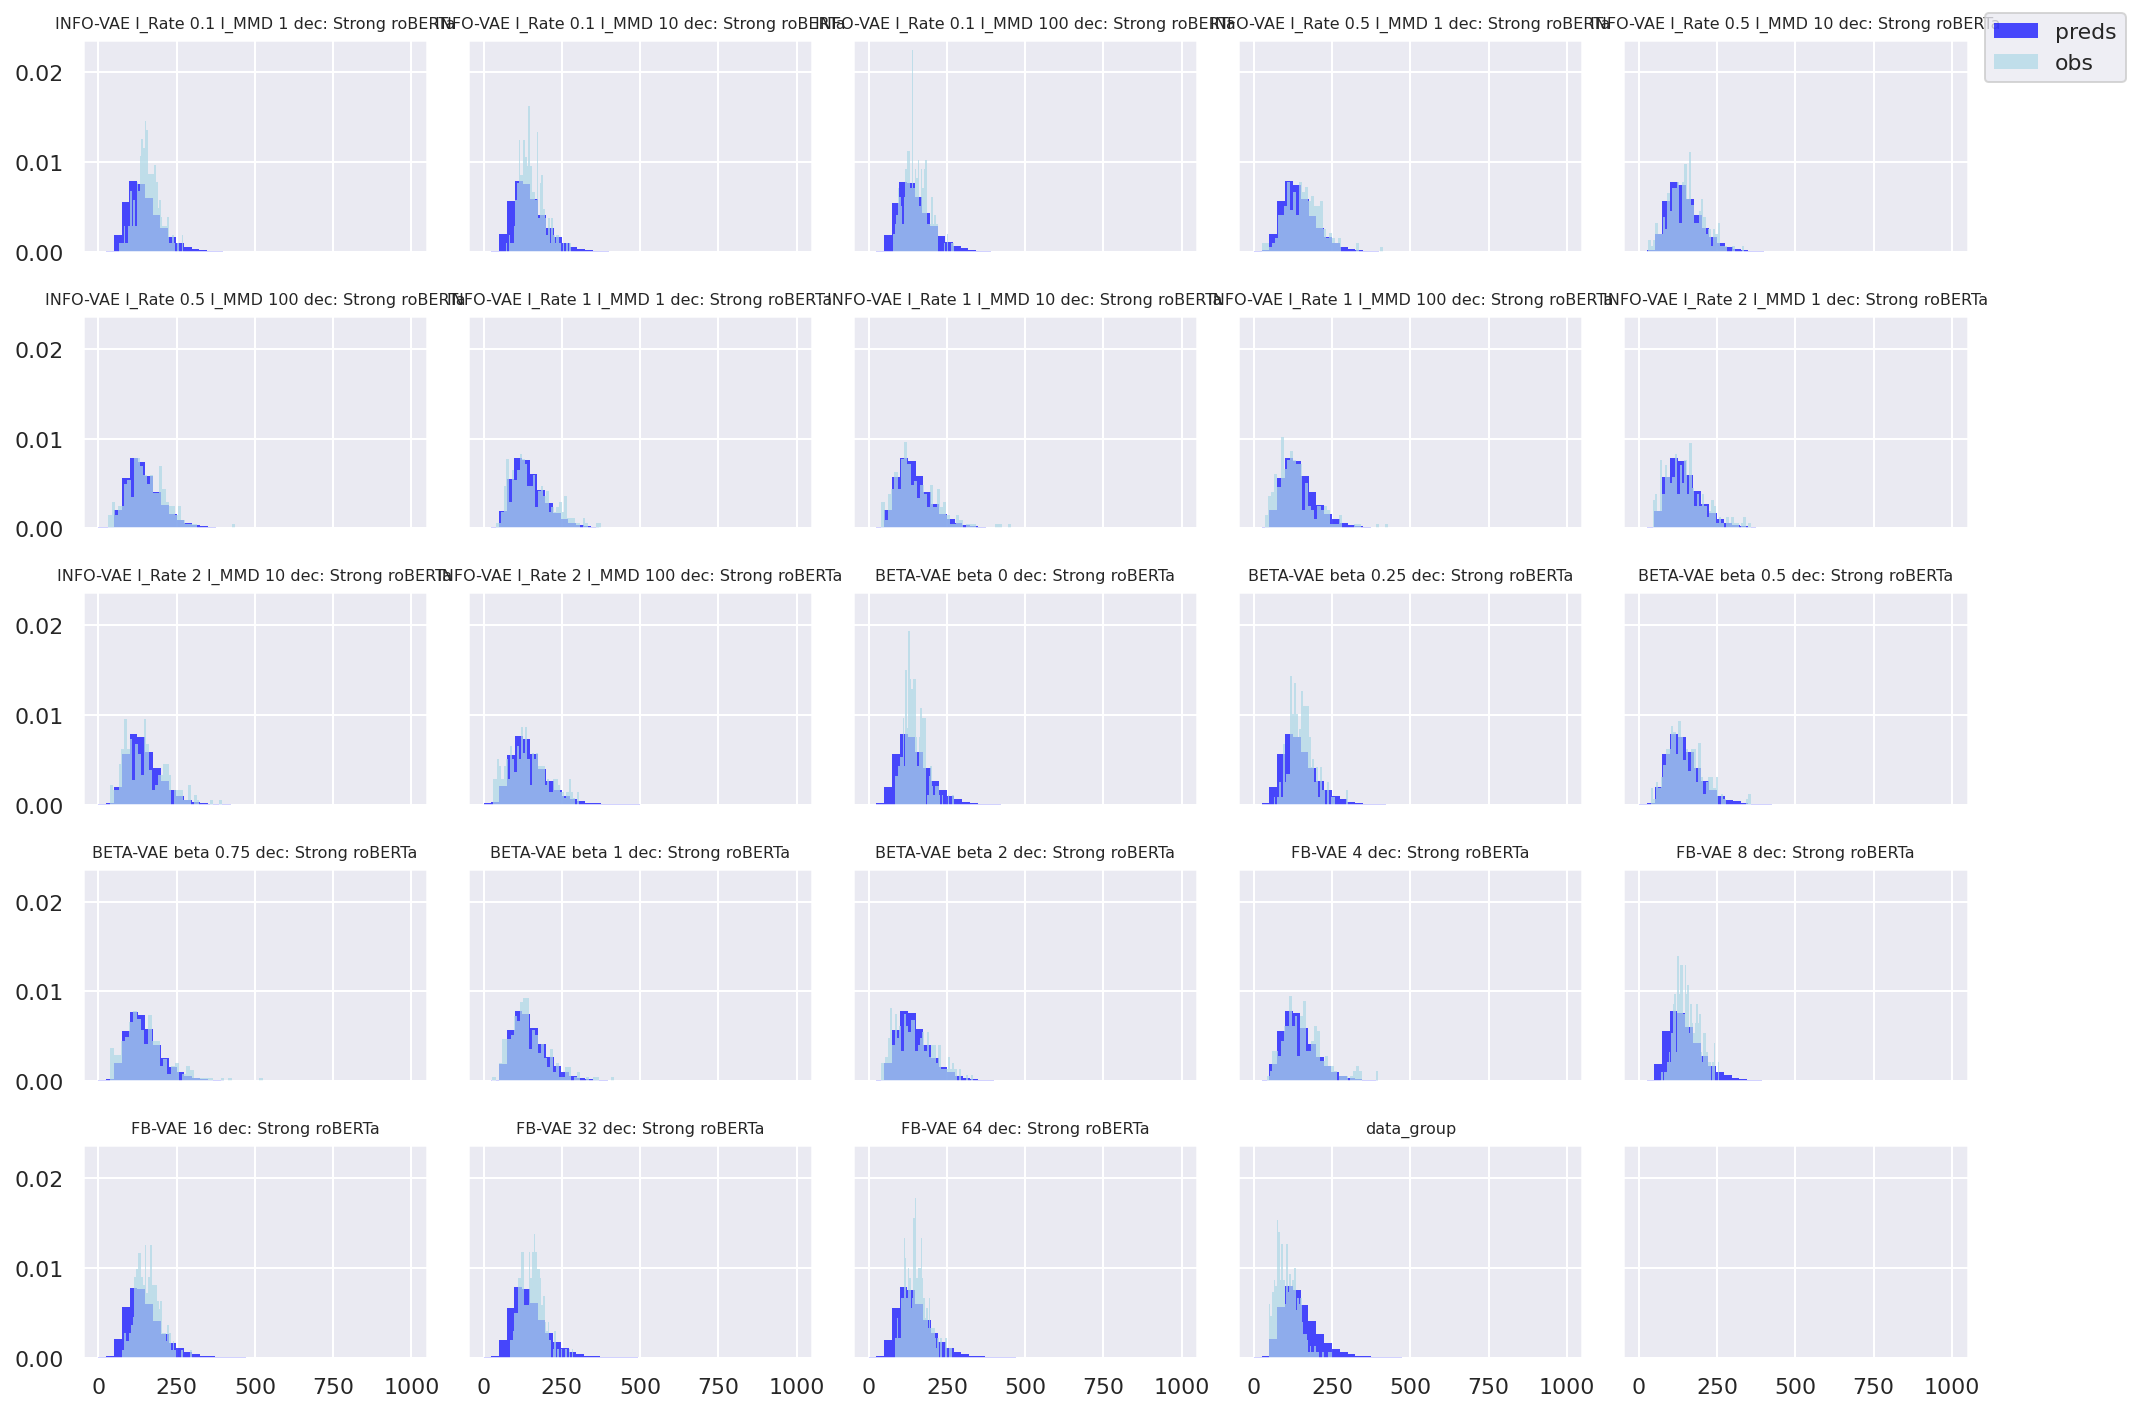

----------------------------------------


In [27]:
RECOMPUTE = False  # <-- set to False if you want to load from pickle

PERFORM_PRIOR_CHECKS = True
PERFORM_POSTERIOR_CHECKS = True

DP_ALPHA = 1.0
OBS_DIST = "log_normal"
# OBS_DIST = "truncated_normal"
TRUNCATED_LOW = 0.0

MAX_GROUPS = 100 # all
MAX_PLOT_CHECK = 1
SKIP_WEAK = True

if RECOMPUTE:
    topic_model_dp_mixtures = dict()
    
    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:
        print(stat_name)
        
        if stat_name in topic_model_dp_mixtures:
            print("Did this one already, continuing..")
            continue

        group_names = []
        observations = []
        
        c = 0
        for i, (k, v) in enumerate(topic_model_surprisal_values.items()):
            if "weak-m" not in k.lower():
                group_names.append(k)
                observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))
                
                c += 1
                if c == MAX_GROUPS:
                    break
                
        if "data_group" not in group_names:
            group_names.append("data_group")
            observations.append(np.array(topic_model_surprisal_values["data_group"][stat_name][:MAX_SAMPLES_PER_GROUP]))
            
        print("Number of groups", len(observations))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist=OBS_DIST,
            truncated_normal_low=TRUNCATED_LOW,
            DP_alpha=DP_ALPHA, 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )
    
        if PERFORM_PRIOR_CHECKS:
            print("-"*40)
            print("PRIOR PREDICTIVE PLOTS")
            prior_samples = dp_mixture.draw_prior_predictions(num_samples=400)
            
            print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
            
            surprisal_dp_plot_checks(dp_mixture, prior_samples["y"], plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
                
            print("-"*40)
            
        dp_mixture.run()

        topic_model_dp_mixtures[stat_name] = dp_mixture
        
        if PERFORM_POSTERIOR_CHECKS:
            print("-"*40)
            print("POSTERIOR PREDICTIVE PLOTS")
            
            posterior_samples = dp_mixture.draw_posterior_predictions()
            samples = posterior_samples["y"]
            
            surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
            print("-"*40)
    
        pickle.dump(topic_model_dp_mixtures, open(TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE, "wb"))

# Load dict with DPs from file
else:
    if os.path.exists(TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE):
        topic_model_dp_mixtures = pickle.load(open(TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE, "rb"))
        
        for stat_name, dp_mixture in topic_model_dp_mixtures.items():
            print("STAT:", stat_name)
            
            if PERFORM_POSTERIOR_CHECKS:
                print("-"*40)
                print("POSTERIOR PREDICTIVE PLOTS")

                posterior_samples = dp_mixture.draw_posterior_predictions()
                samples = posterior_samples["y"]
                surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
                plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
                plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
                print("-"*40)
    else:
        print(f"No DPs saved in TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE={TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE}, set FIT_SURPRISAL_DPS=True to re-run.")

# PTB - Sequence length

## Load surprisal values

In [9]:
if os.path.exists(SEQUENCE_LEN_SAVE_BDA_SURPRISAL_VALS_FILE):
    sequence_len_surprisal_values = torch.load(SEQUENCE_LEN_SAVE_BDA_SURPRISAL_VALS_FILE)
else:
    print(f"Surprisal values not found in {SEQUENCE_LEN_SAVE_BDA_SURPRISAL_VALS_FILE}")

## Plot surprisal values

Rows: 22, cols: 3, every: 1, n_groups: 22


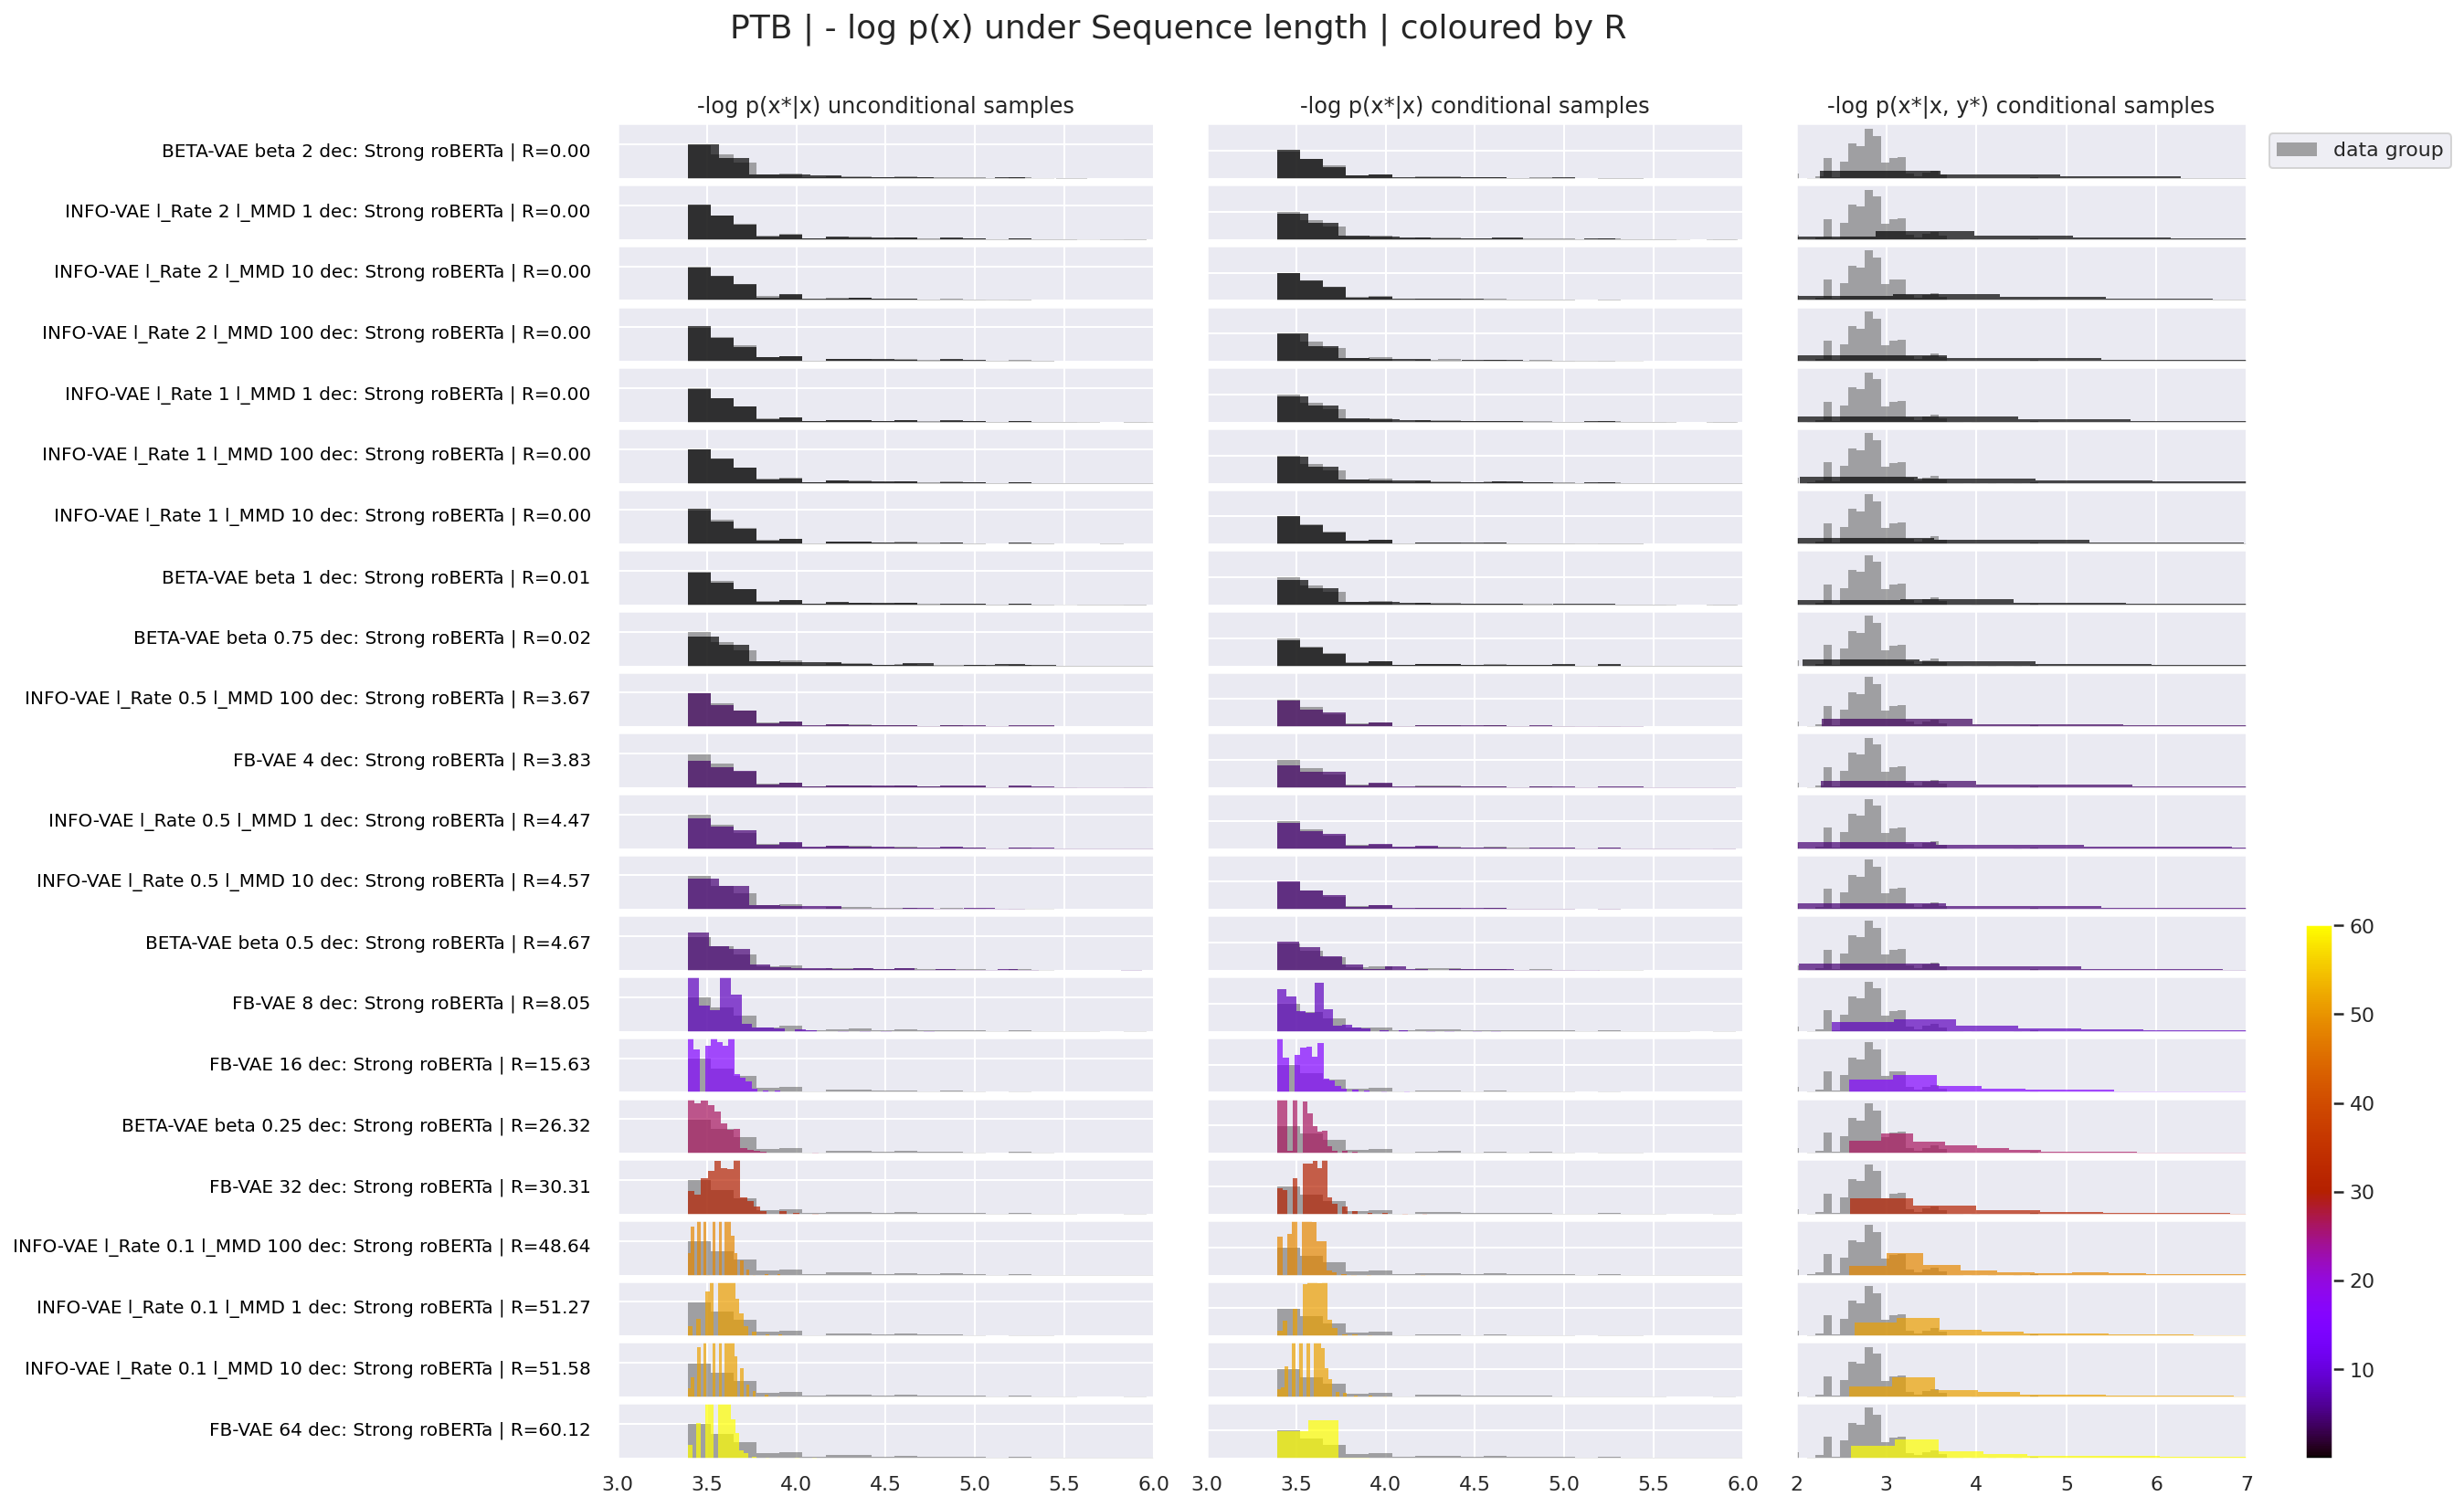

In [21]:
xlims = [[3, 6], [3, 6], [2, 7]]
ylims = [[0, 4.0], [0, 4.9], [0, 2.]]

# Filter out high rate model for visualisation purposes and load the PTB (language) experiments only
global_stats_df_filter = global_stats_df[(global_stats_df["kl_prior_post"] < 150) \
                                         & ((global_stats_df["image_or_language"] == "language"))]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=sequence_len_surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="PTB",
                                         latent_structure="Sequence length",
                                         sort_name="R", 
                                         cm_shrink=0.4,
                                         cm_name="gnuplot",
                                         bins=30,
                                         title_size=18,
                                         title_y=1.04,
                                         subsample_nrows=None, 
                                         sort_ascend=True, 
                                         row_height=0.5)

## Fit 3 DP Mixtures on 3 types of surprisal values

1. unconditional_unconditional: unconditional surprisal statistic on unconditional samples
2. unconditional_unconditional: unconditional surprisal statistic on conditional samples
3. unconditional_unconditional: conditional surprisal statistic on conditional samples

STAT: unconditional_unconditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 3.7723365 std y: 0.57058513 min_y: 3.393774 max y: 8.547491


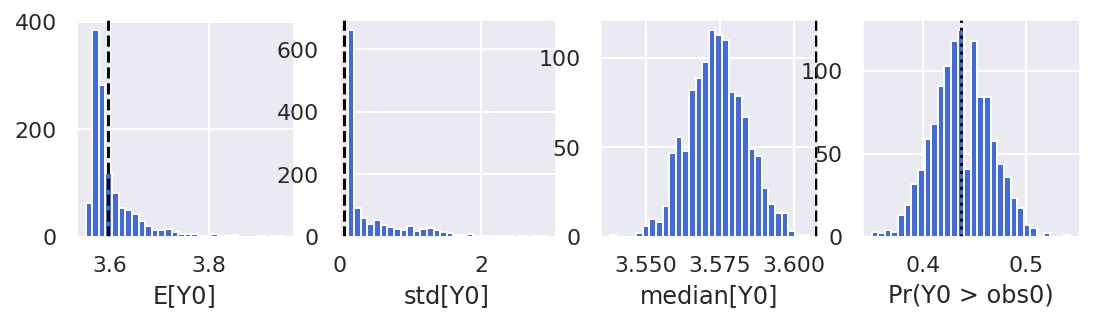

mean y: 3.7723365 std y: 0.57058513 min_y: 3.393774 max y: 8.547491


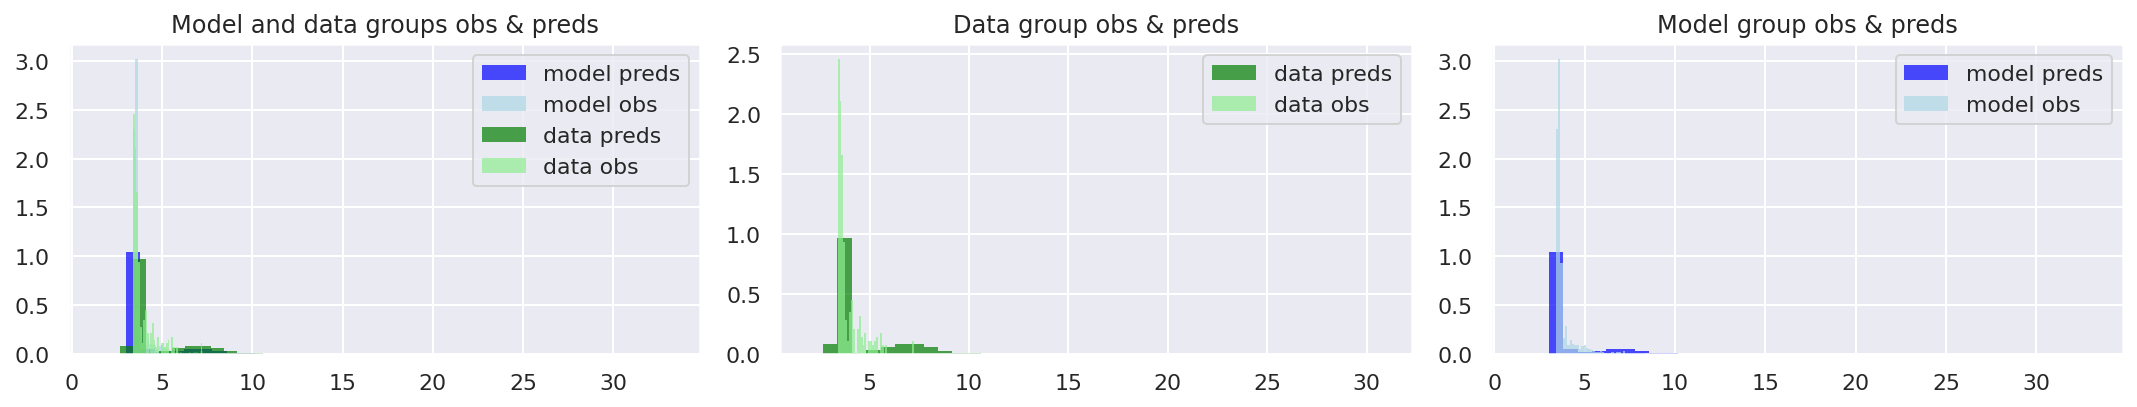

mean y: 3.7723365 std y: 0.57058513 min_y: 3.393774 max y: 8.547491


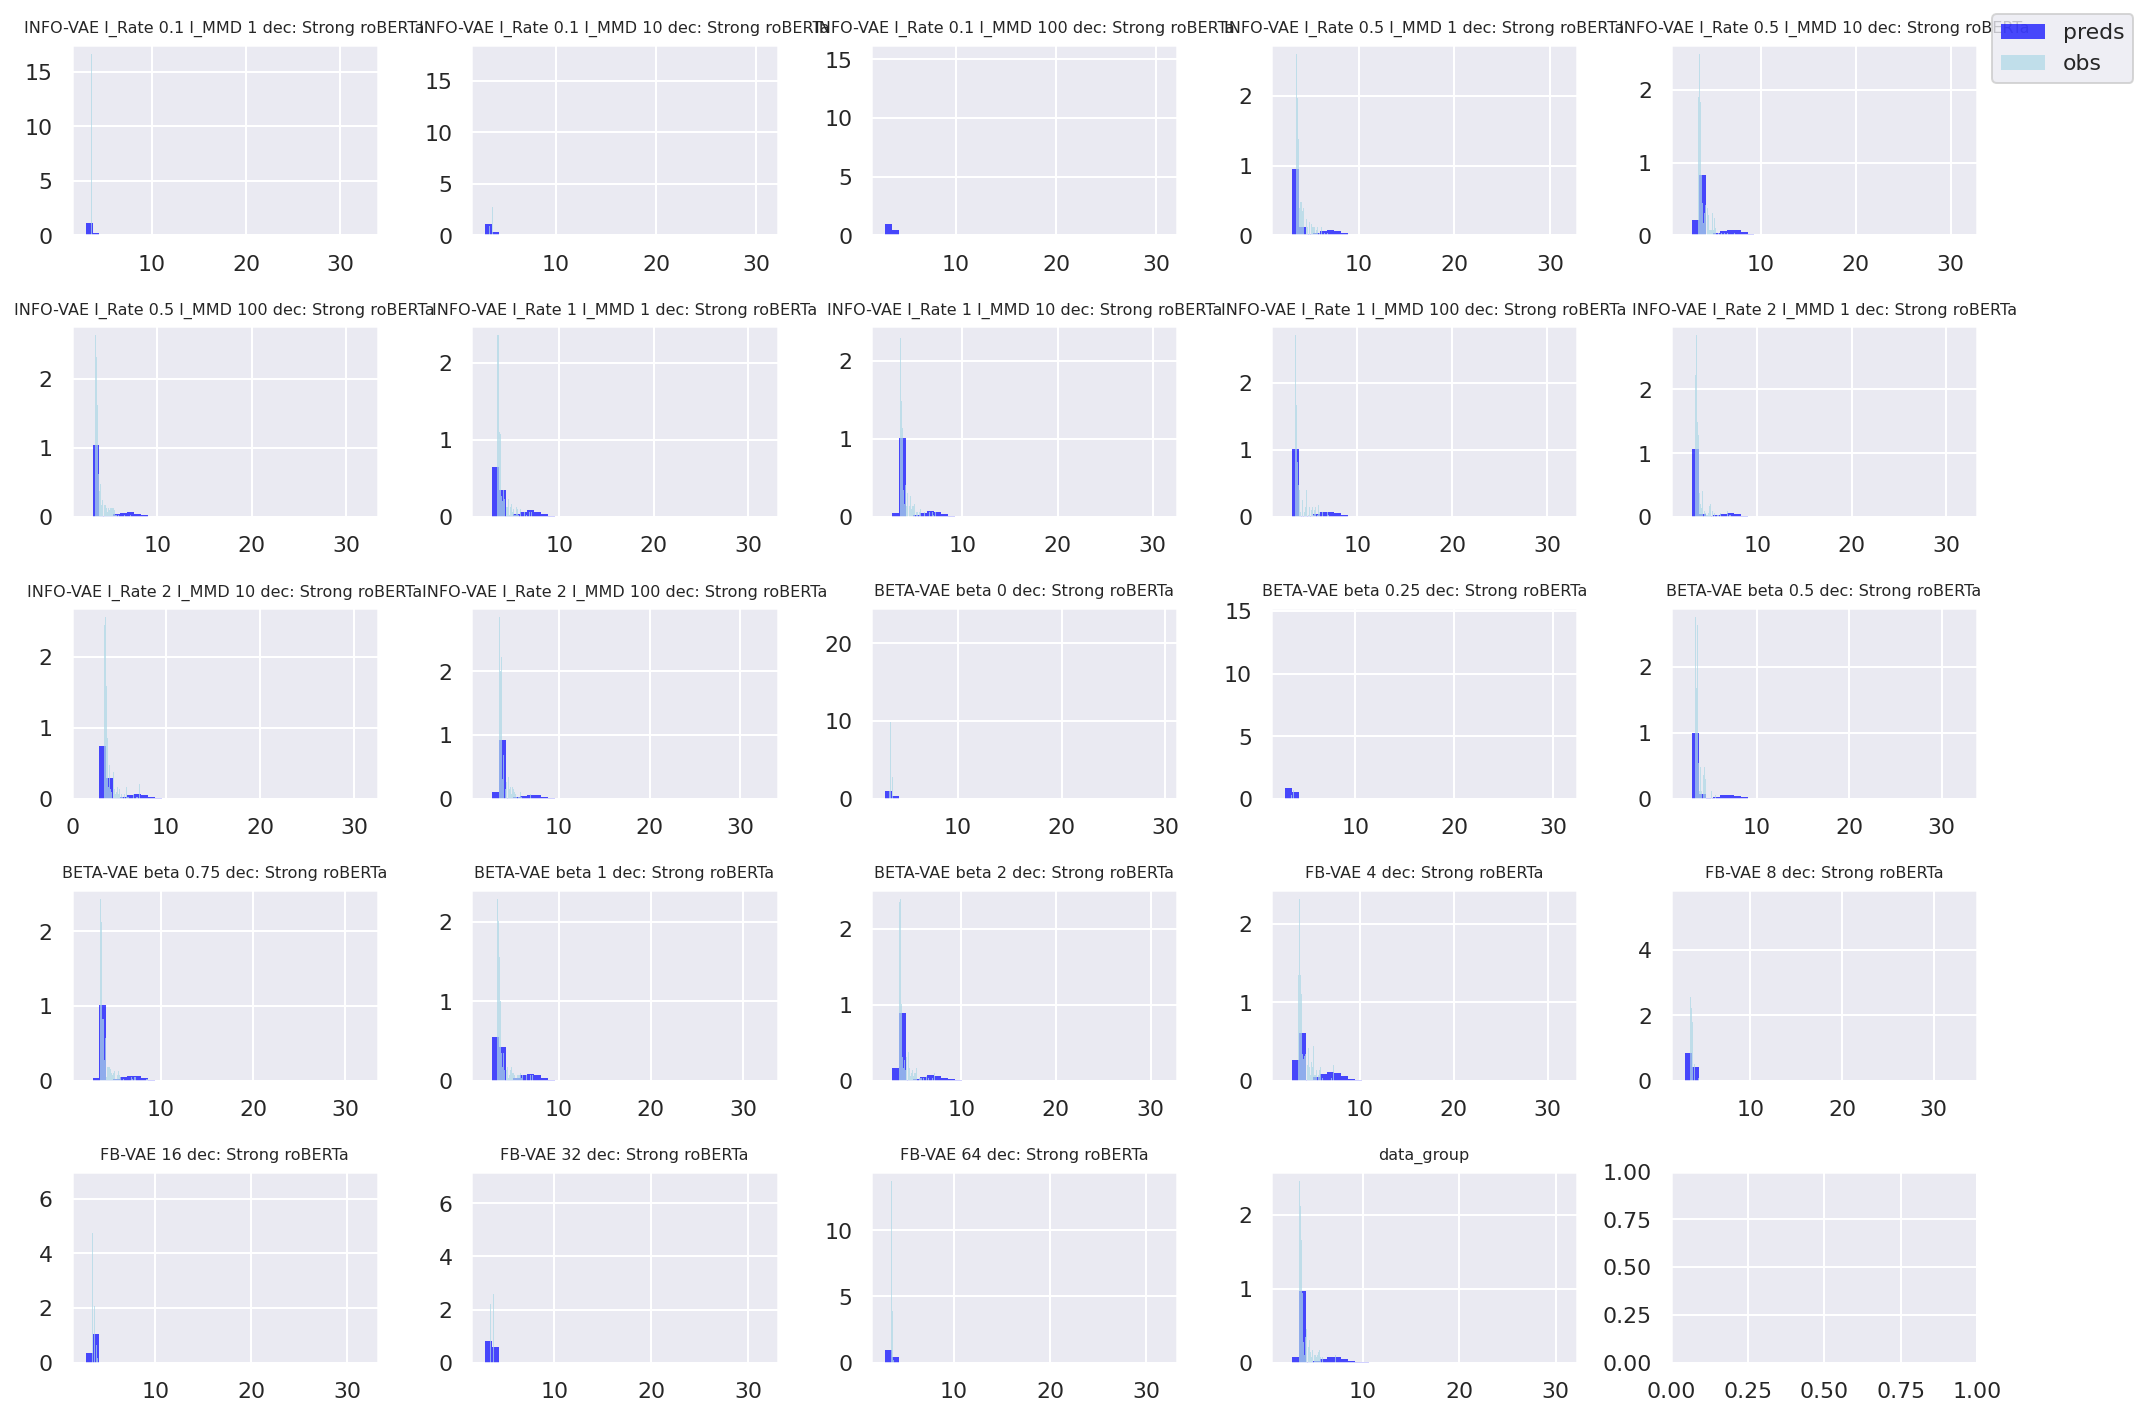

----------------------------------------
STAT: unconditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 3.76411 std y: 0.5643525 min_y: 3.393774 max y: 7.242527


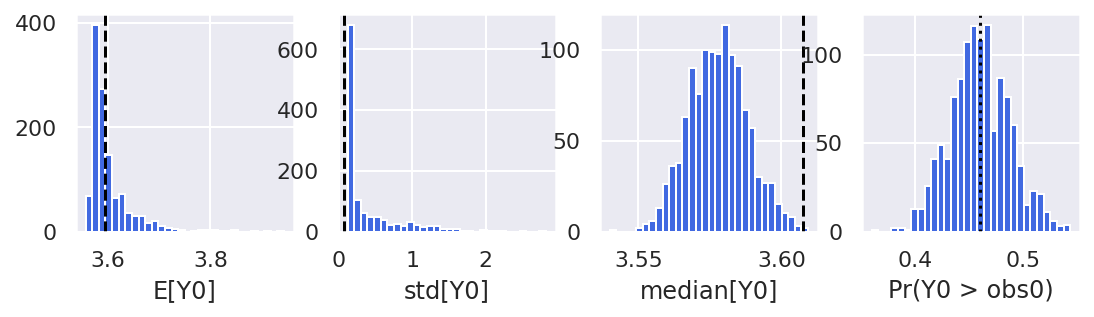

mean y: 3.76411 std y: 0.5643525 min_y: 3.393774 max y: 7.242527


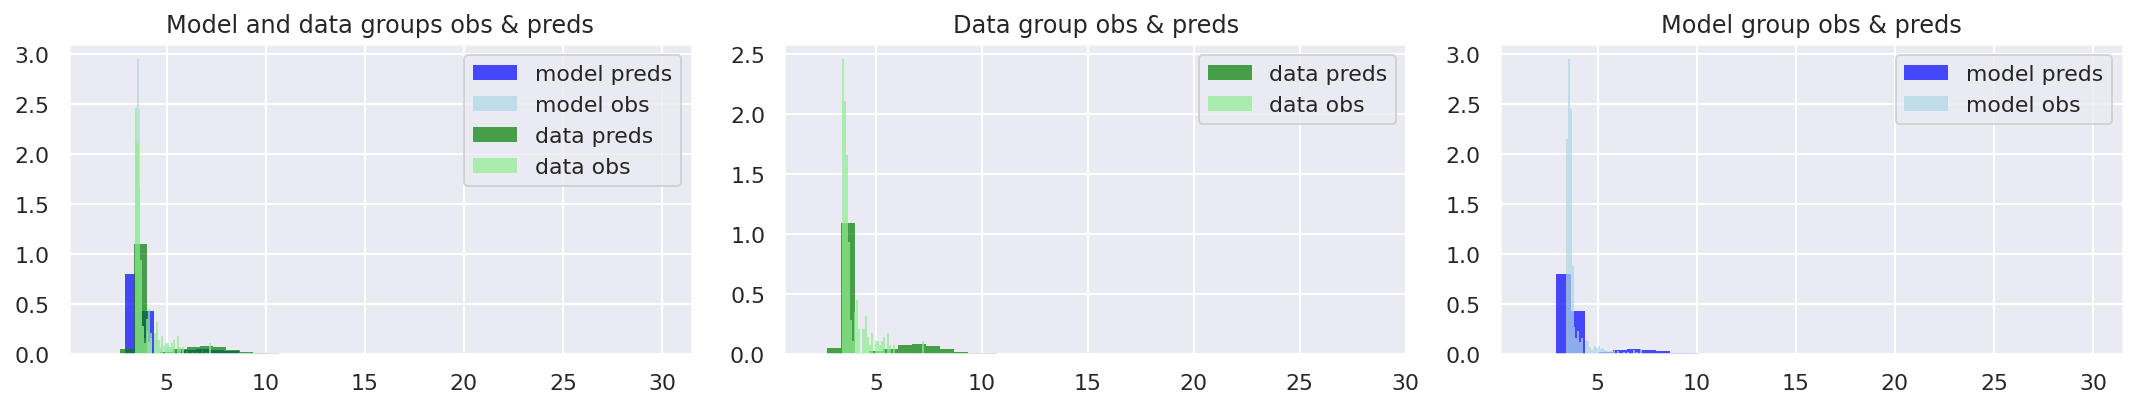

mean y: 3.76411 std y: 0.5643525 min_y: 3.393774 max y: 7.242527


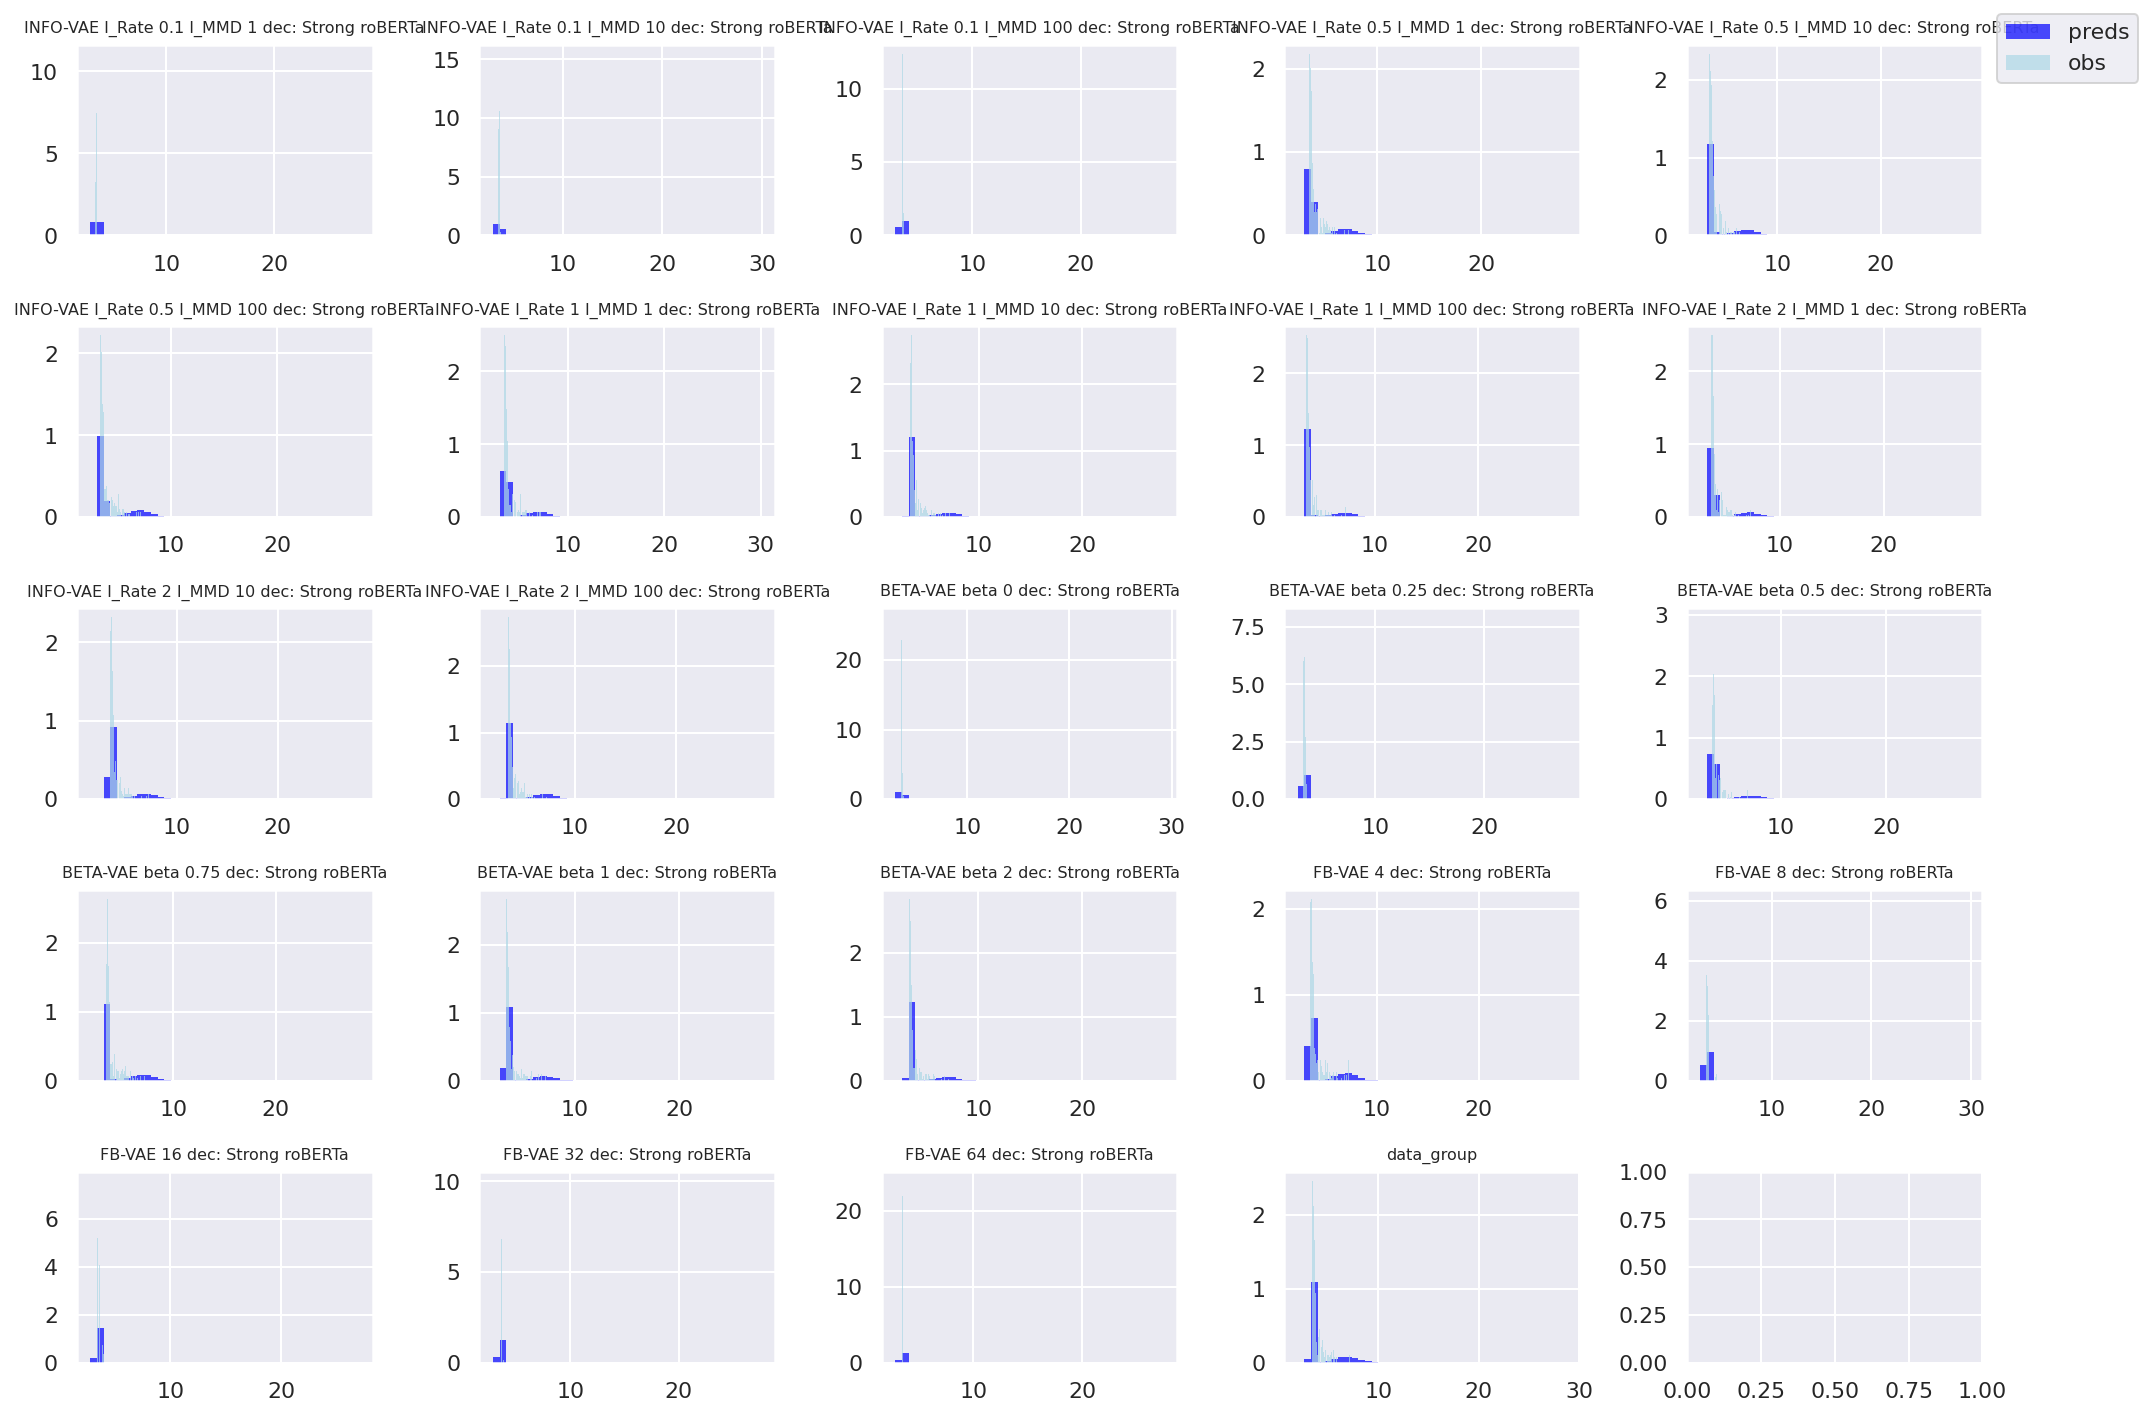

----------------------------------------
STAT: conditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 4.8170924 std y: 3.185676 min_y: 1.8832312 max y: 54.11833


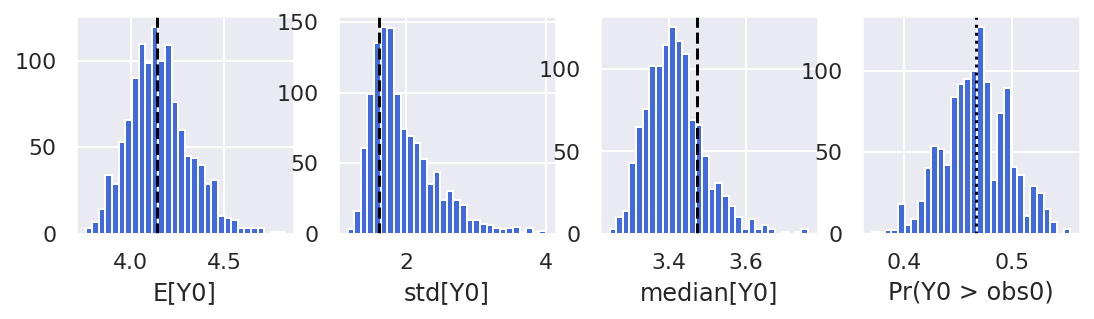

mean y: 4.8170924 std y: 3.185676 min_y: 1.8832312 max y: 54.11833


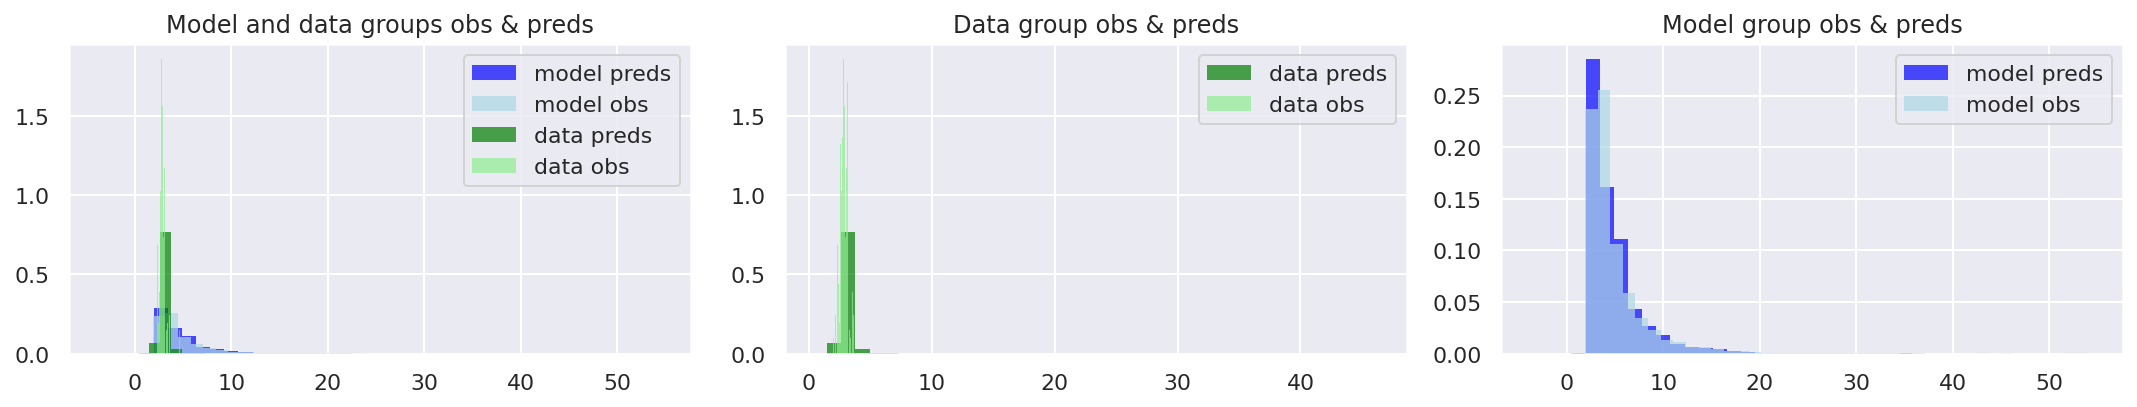

mean y: 4.8170924 std y: 3.185676 min_y: 1.8832312 max y: 54.11833


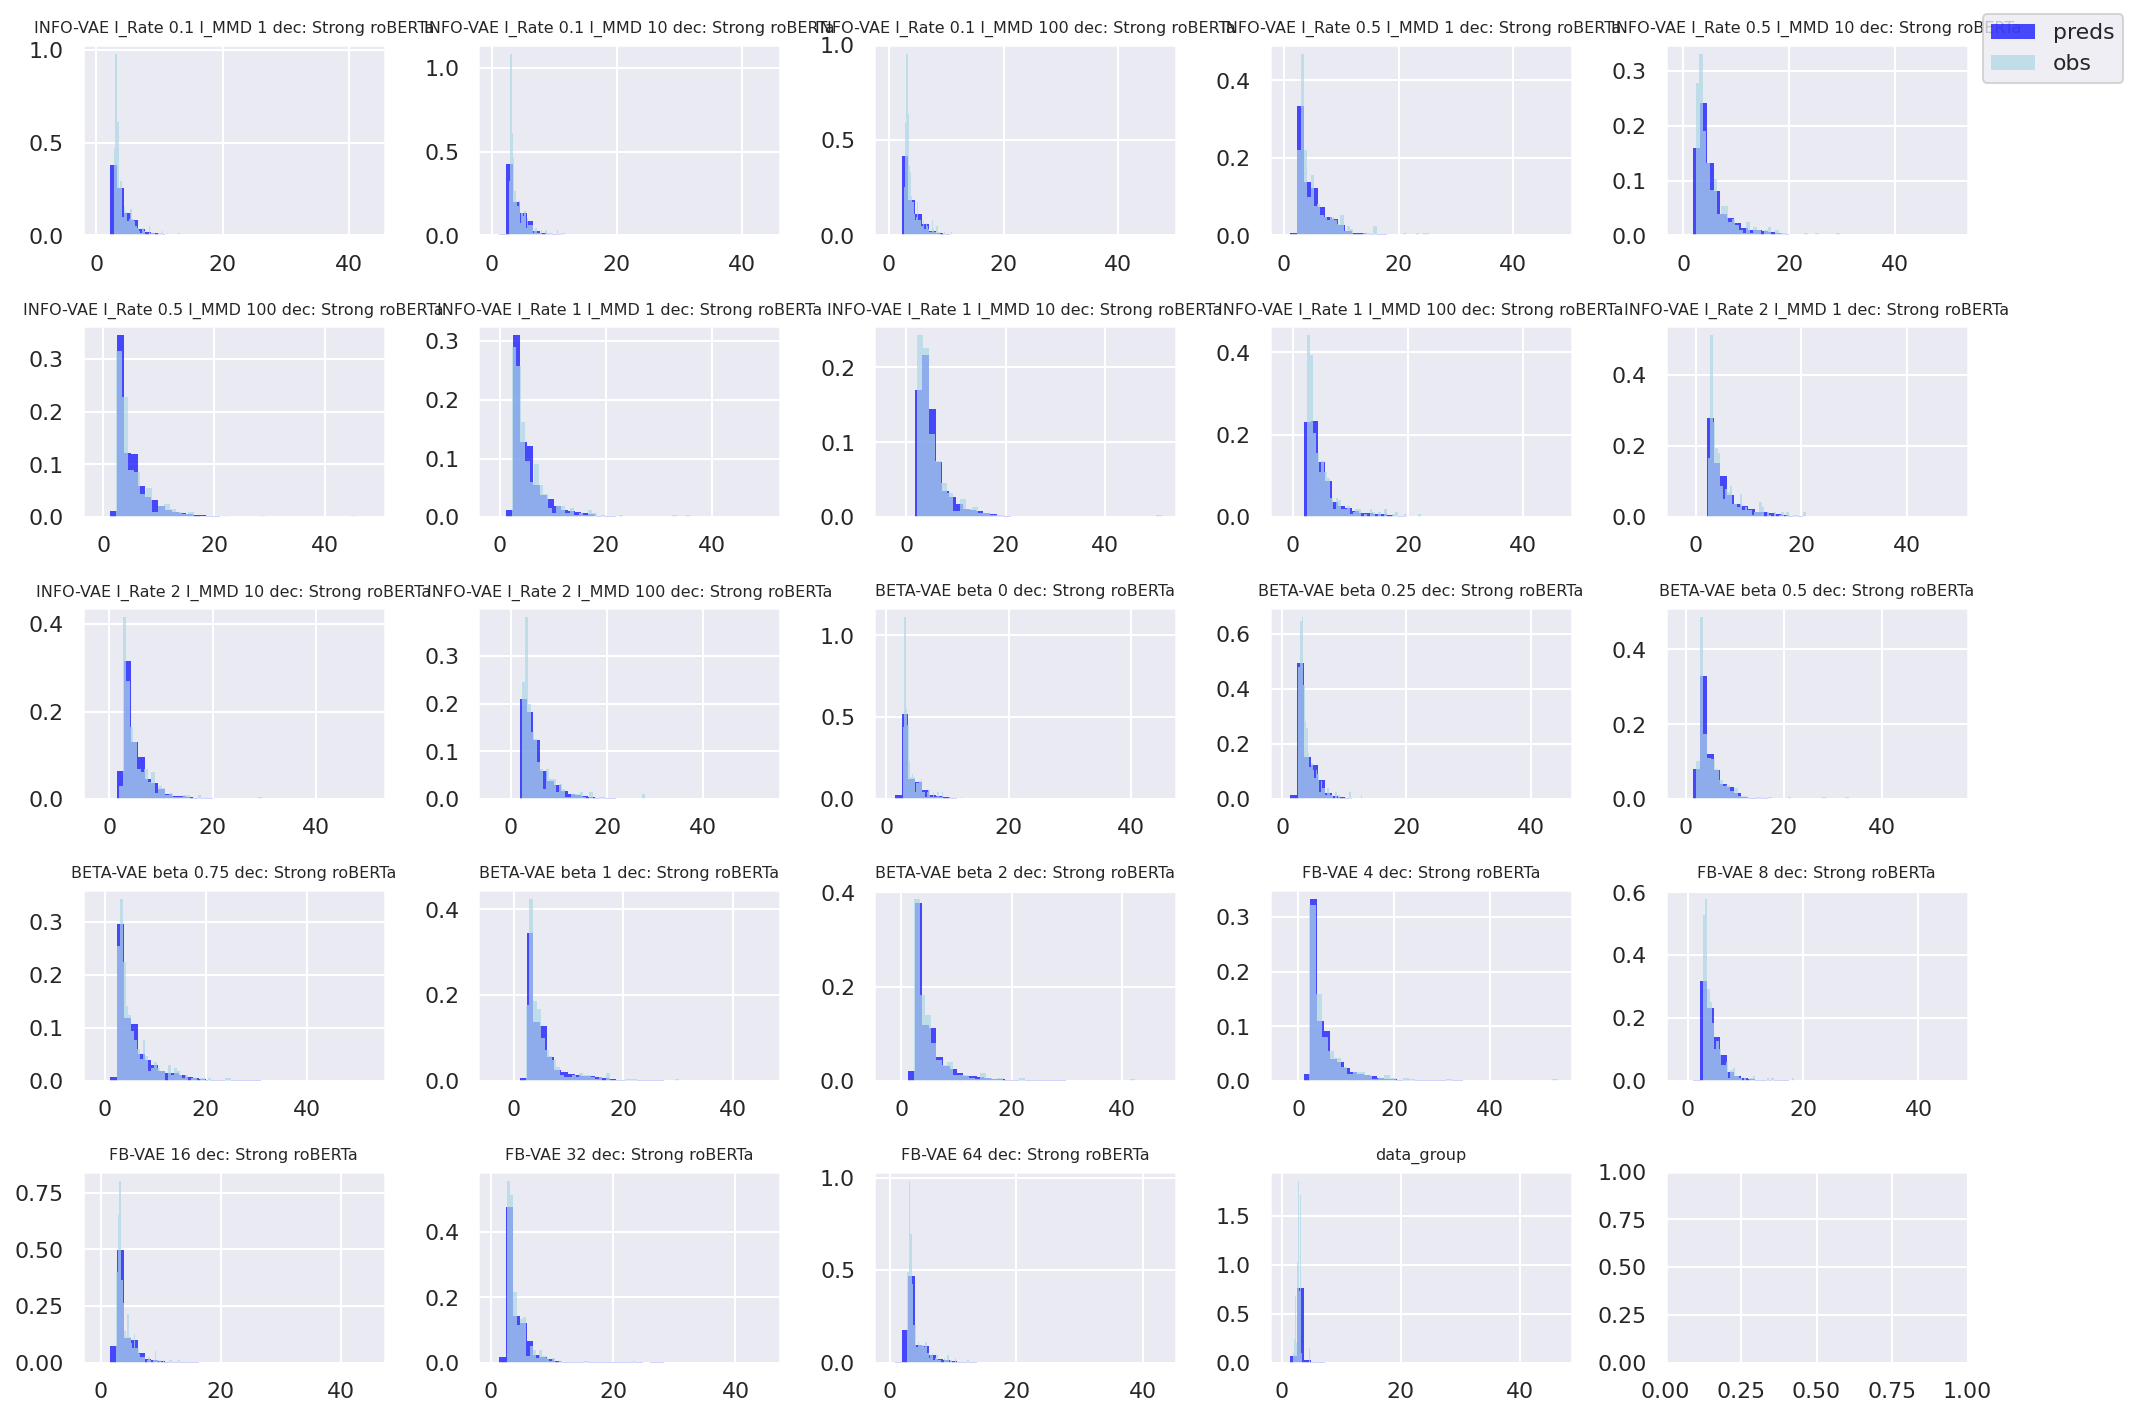

----------------------------------------


In [14]:
RECOMPUTE = False  # <-- set to False if you want to load from pickle

PERFORM_PRIOR_CHECKS = True
PERFORM_POSTERIOR_CHECKS = True

DP_ALPHA = 1.0
OBS_DIST = "log_normal"
TRUNCATED_LOW = 0.0

MAX_GROUPS = 100 # all
MAX_PLOT_CHECK = 1

if RECOMPUTE:
    sequence_length_dp_mixtures = dict()
    
    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:
        print(stat_name)
        
        if stat_name in sequence_length_dp_mixtures:
            print("Did this one already, continuing..")
            continue

        group_names = []
        observations = []
        
        c = 0
        for i, (k, v) in enumerate(sequence_len_surprisal_values.items()):
            group_names.append(k)
            observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

            c += 1
            if c == MAX_GROUPS:
                break
                
        if "data_group" not in group_names:
            group_names.append("data_group")
            observations.append(np.array(sequence_len_surprisal_values["data_group"][stat_name][:MAX_SAMPLES_PER_GROUP]))
            
        print("Number of groups", len(observations))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist=OBS_DIST,
            truncated_normal_low=TRUNCATED_LOW,
            DP_alpha=DP_ALPHA, 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )
    
        if PERFORM_PRIOR_CHECKS:
            print("-"*40)
            print("PRIOR PREDICTIVE PLOTS")
            prior_samples = dp_mixture.draw_prior_predictions(num_samples=400)
            
            print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
            
            surprisal_dp_plot_checks(dp_mixture, prior_samples["y"], plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
                
            print("-"*40)
            
        dp_mixture.run()

        sequence_length_dp_mixtures[stat_name] = dp_mixture
        
        if PERFORM_POSTERIOR_CHECKS:
            print("-"*40)
            print("POSTERIOR PREDICTIVE PLOTS")
            
            posterior_samples = dp_mixture.draw_posterior_predictions()
            samples = posterior_samples["y"]
            
            surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
            print("-"*40)
    
        pickle.dump(mnist_dp_mixtures, open(SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE, "wb"))
    
else:
    if os.path.exists(SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE):
        
        sequence_length_dp_mixtures = pickle.load(open(SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE, "rb"))
        
        for stat_name, dp_mixture in sequence_length_dp_mixtures.items():
            print("STAT:", stat_name)
            if PERFORM_POSTERIOR_CHECKS:
                print("-"*40)
                print("POSTERIOR PREDICTIVE PLOTS")

                posterior_samples = dp_mixture.draw_posterior_predictions()
                samples = posterior_samples["y"]

                surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
                plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
                plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3, sharex=False, sharey=False)
                print("-"*40)
    else:
        print(f"No DPs saved in SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE={SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE}, set RECOMPUTE=True to re-run.")
        

# MNIST

## Load surprisal values

In [17]:
if os.path.exists(MNIST_SAVE_BDA_SURPRISAL_VALS_FILE):
    mnist_surprisal_values = torch.load(MNIST_SAVE_BDA_SURPRISAL_VALS_FILE)
else:
    print(f"Surprisal values not found in {MNIST_SAVE_BDA_SURPRISAL_VALS_FILE}")

## Plot surprisal values

Rows: 48, cols: 3, every: 1, n_groups: 48


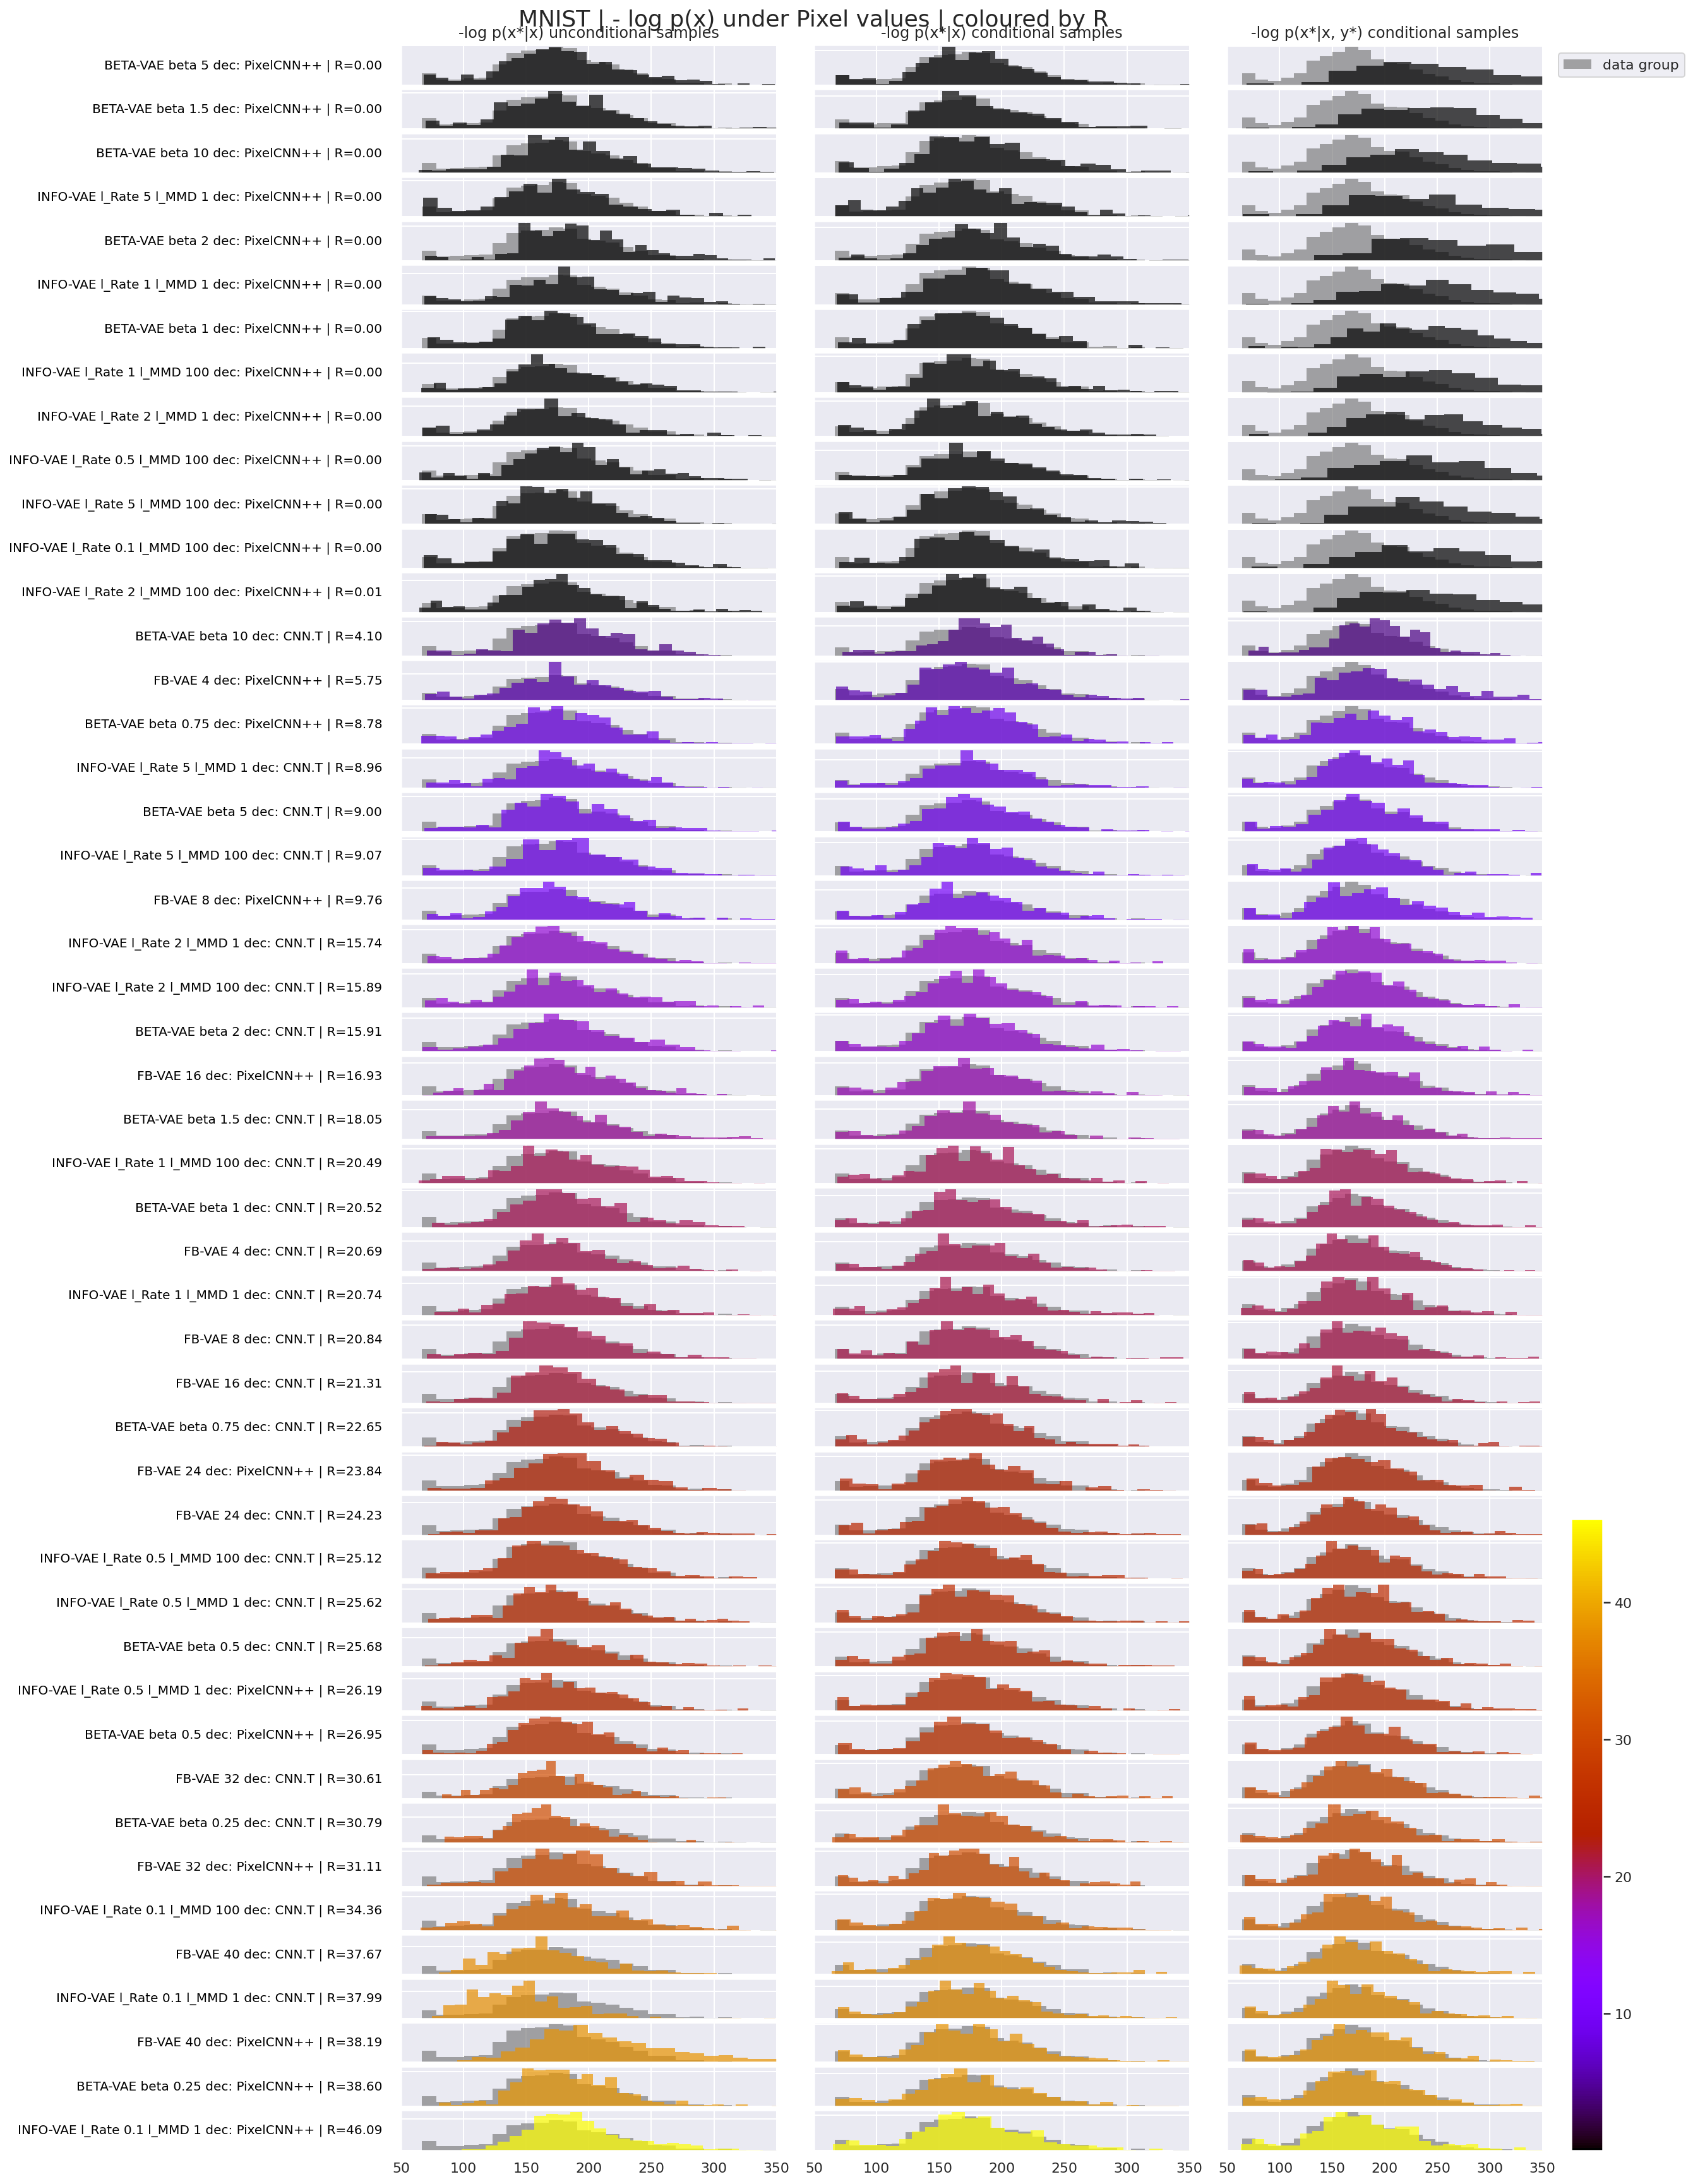

In [22]:
xlims = [[50, 350], [50, 350], [50, 350]]
ylims = [None, None, None]

# MNIST experiments only
global_stats_df_filter = global_stats_df[global_stats_df["image_or_language"] == "image"]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=mnist_surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="R", 
                                         bins=30,
                                         cm_shrink=0.3,
                                         cm_name="gnuplot",
                                         title_size=18,
                                         title_y=1.0,
                                         subsample_nrows=None,
                                         sort_ascend=True, 
                                         row_height=0.5)

STAT: unconditional_unconditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 180.80988 std y: 47.292107 min_y: 63.977966 max y: 430.22147


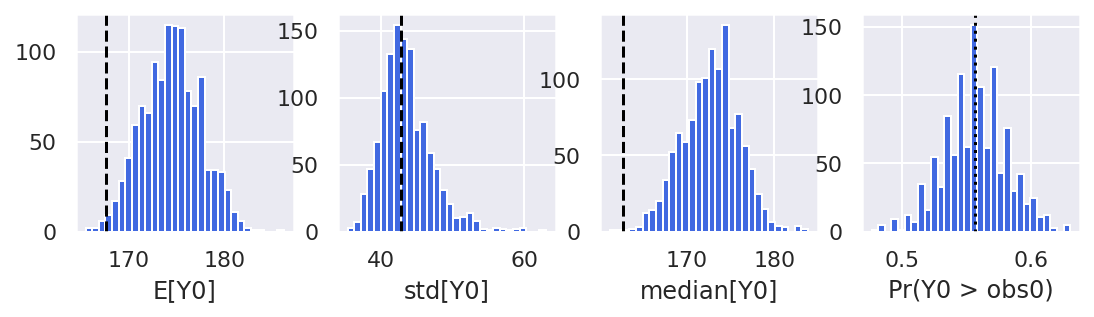

mean y: 180.80988 std y: 47.292107 min_y: 63.977966 max y: 430.22147


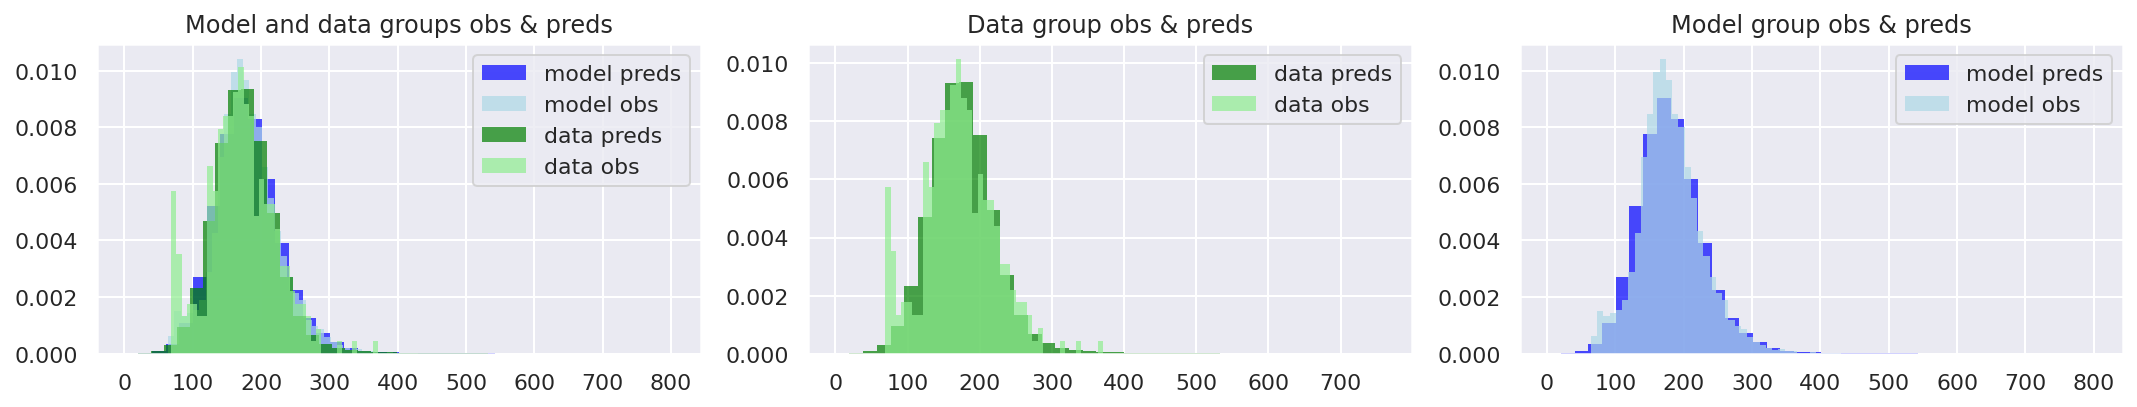

mean y: 180.80988 std y: 47.292107 min_y: 63.977966 max y: 430.22147


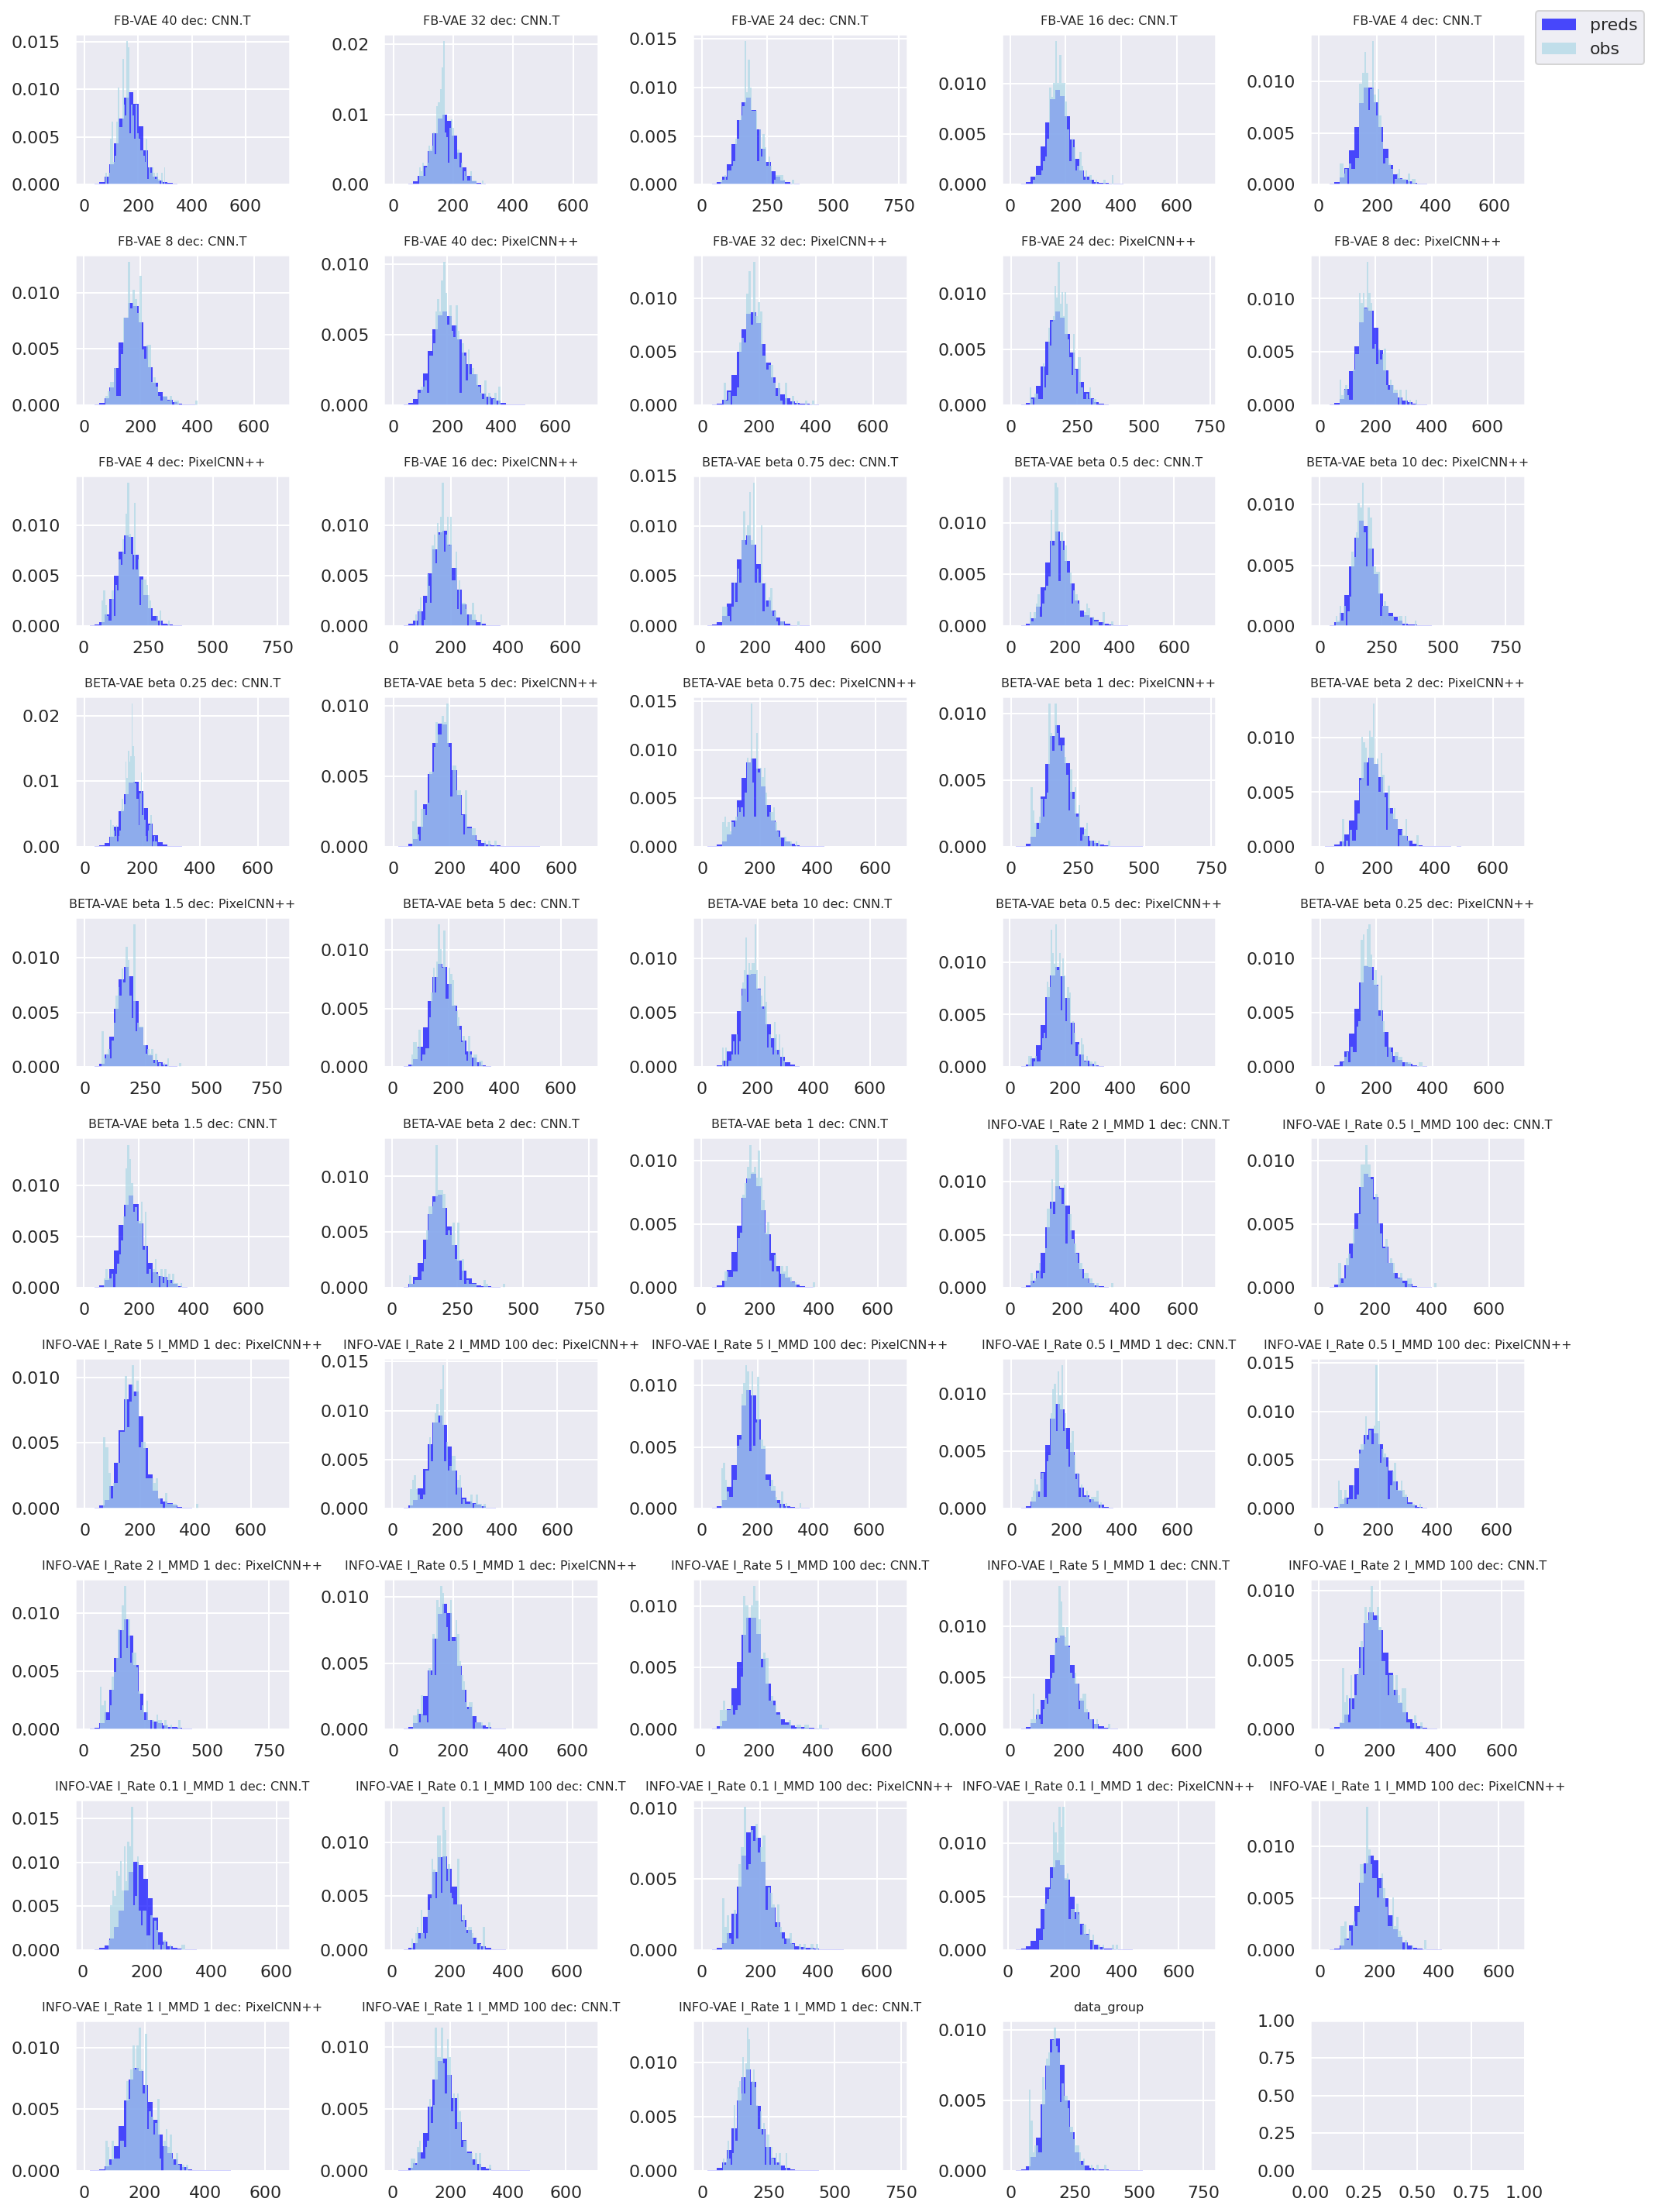

----------------------------------------
STAT: unconditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 176.21594 std y: 48.05971 min_y: 64.09842 max y: 401.3998


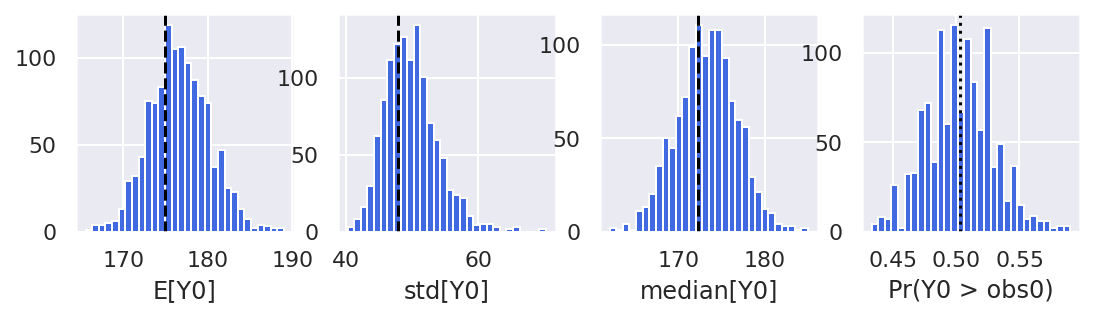

mean y: 176.21594 std y: 48.05971 min_y: 64.09842 max y: 401.3998


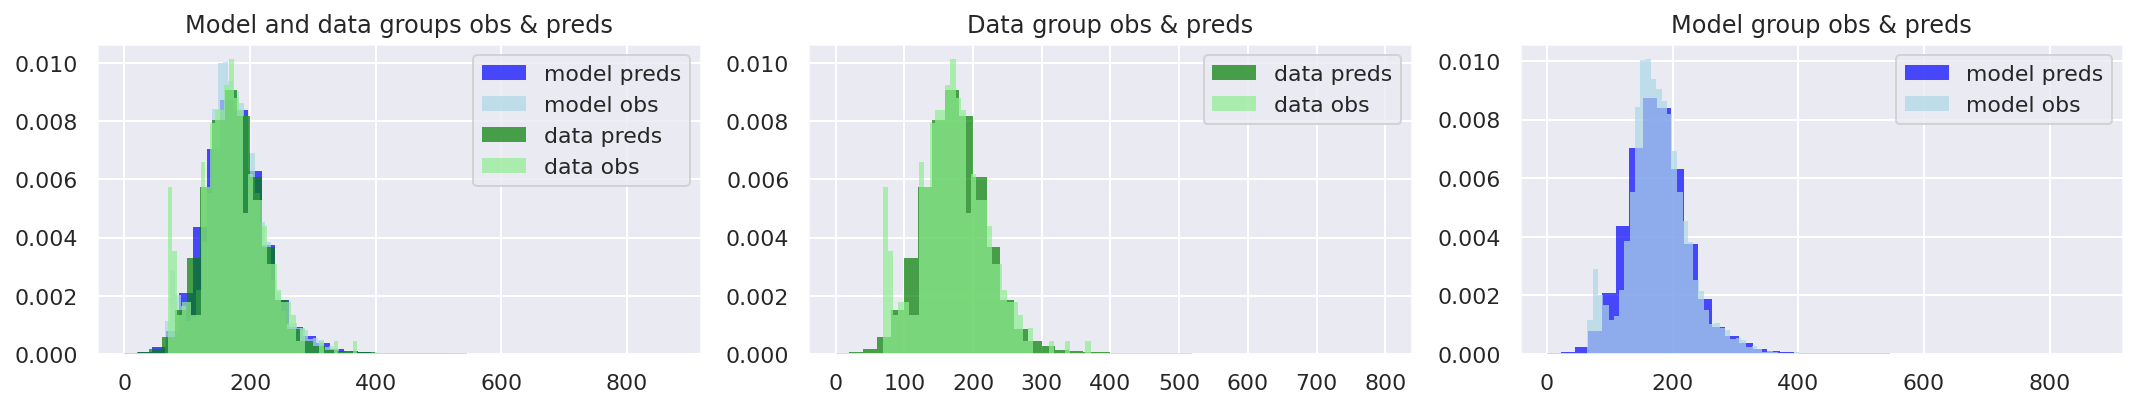

mean y: 176.21594 std y: 48.05971 min_y: 64.09842 max y: 401.3998


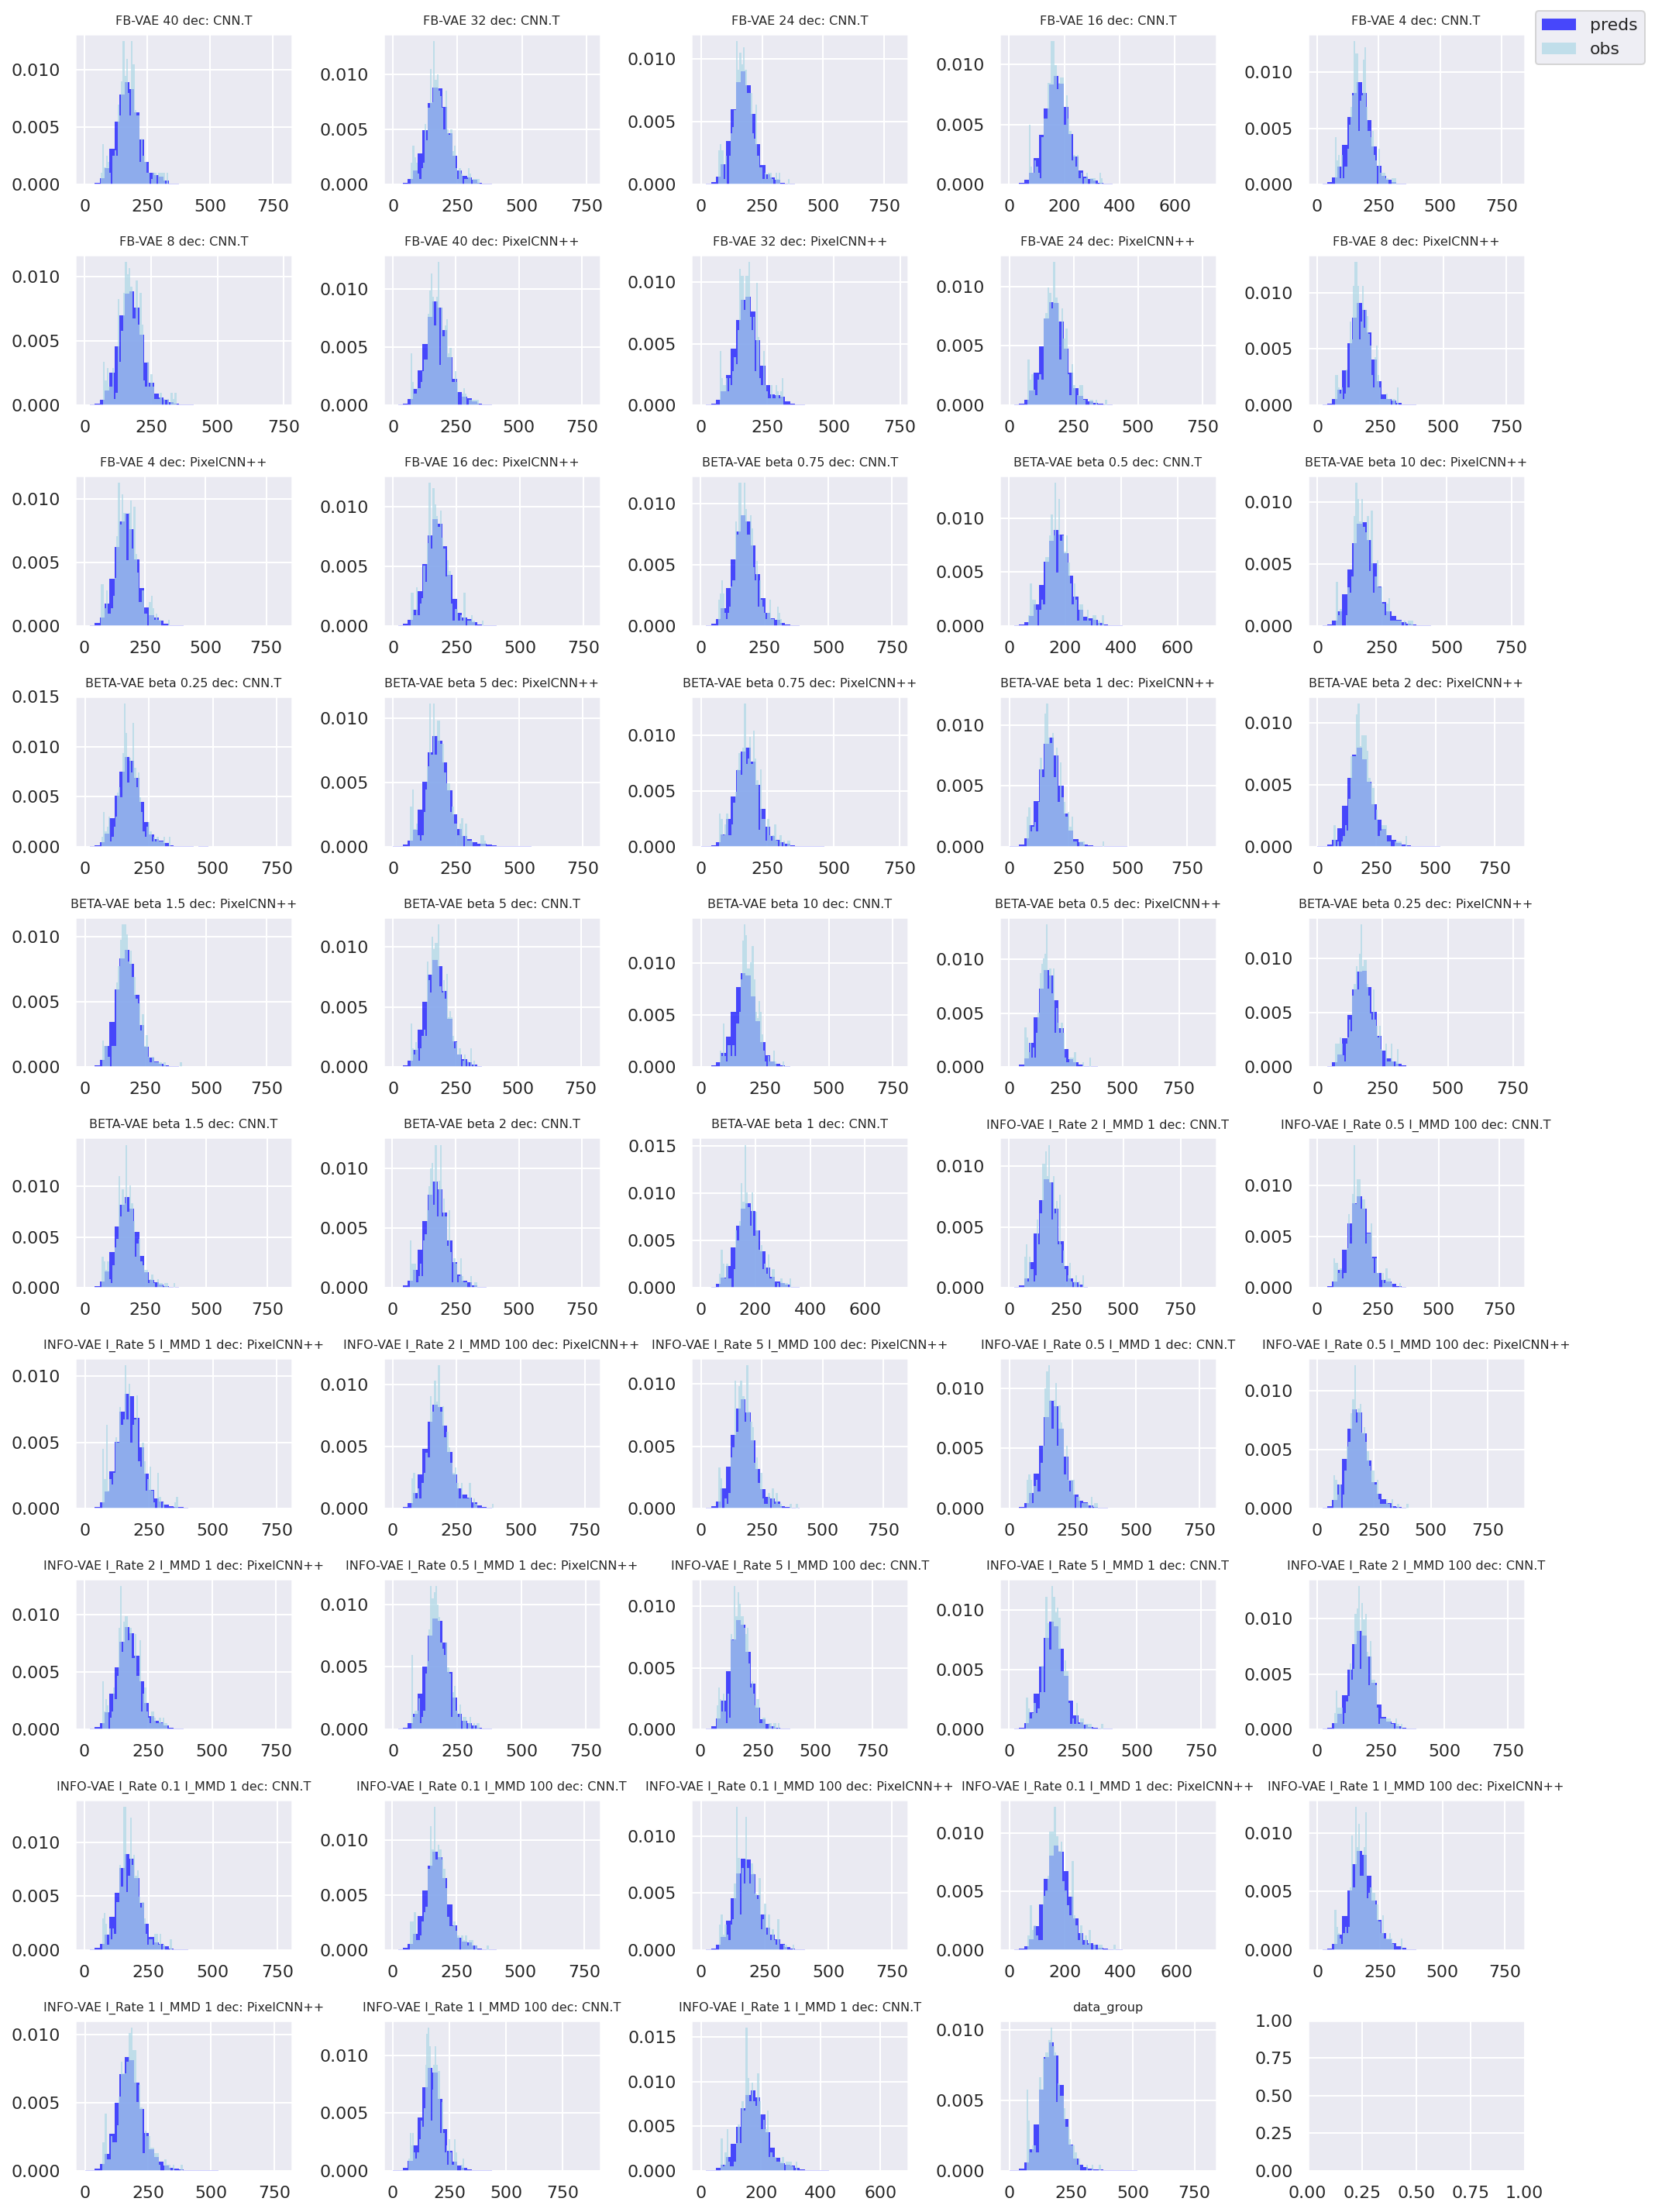

----------------------------------------
STAT: conditional_conditional
----------------------------------------
POSTERIOR PREDICTIVE PLOTS
mean y: 201.04247 std y: 75.53056 min_y: 61.795834 max y: 895.80646
Warning, values higher than 1000.0, filtering those out.


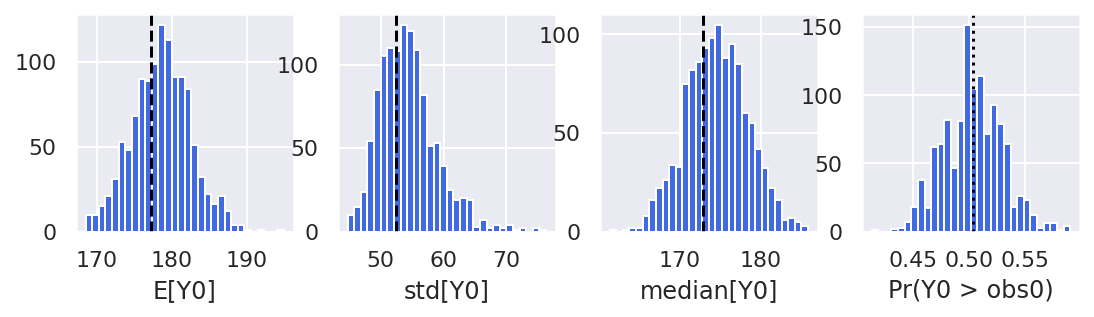

mean y: 201.04247 std y: 75.53056 min_y: 61.795834 max y: 895.80646
Warning, values higher than 1000.0, filtering those out.


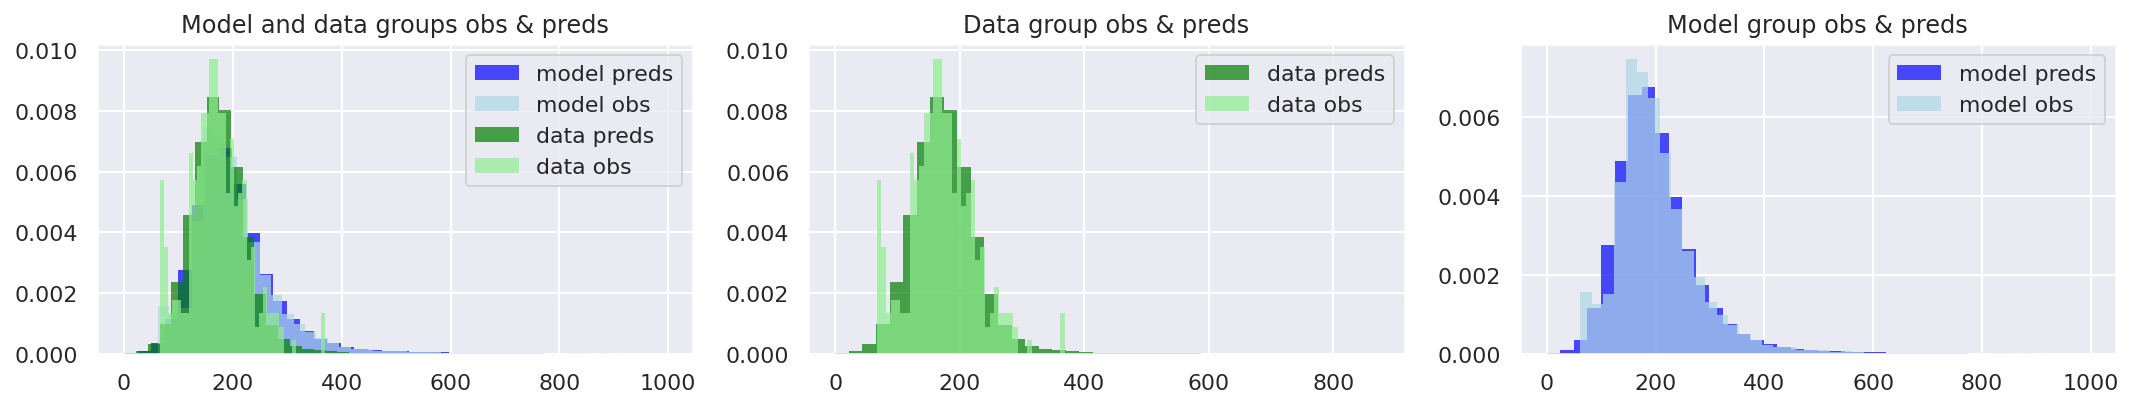

mean y: 201.04247 std y: 75.53056 min_y: 61.795834 max y: 895.80646
Warning, values higher than 1000.0, filtering those out


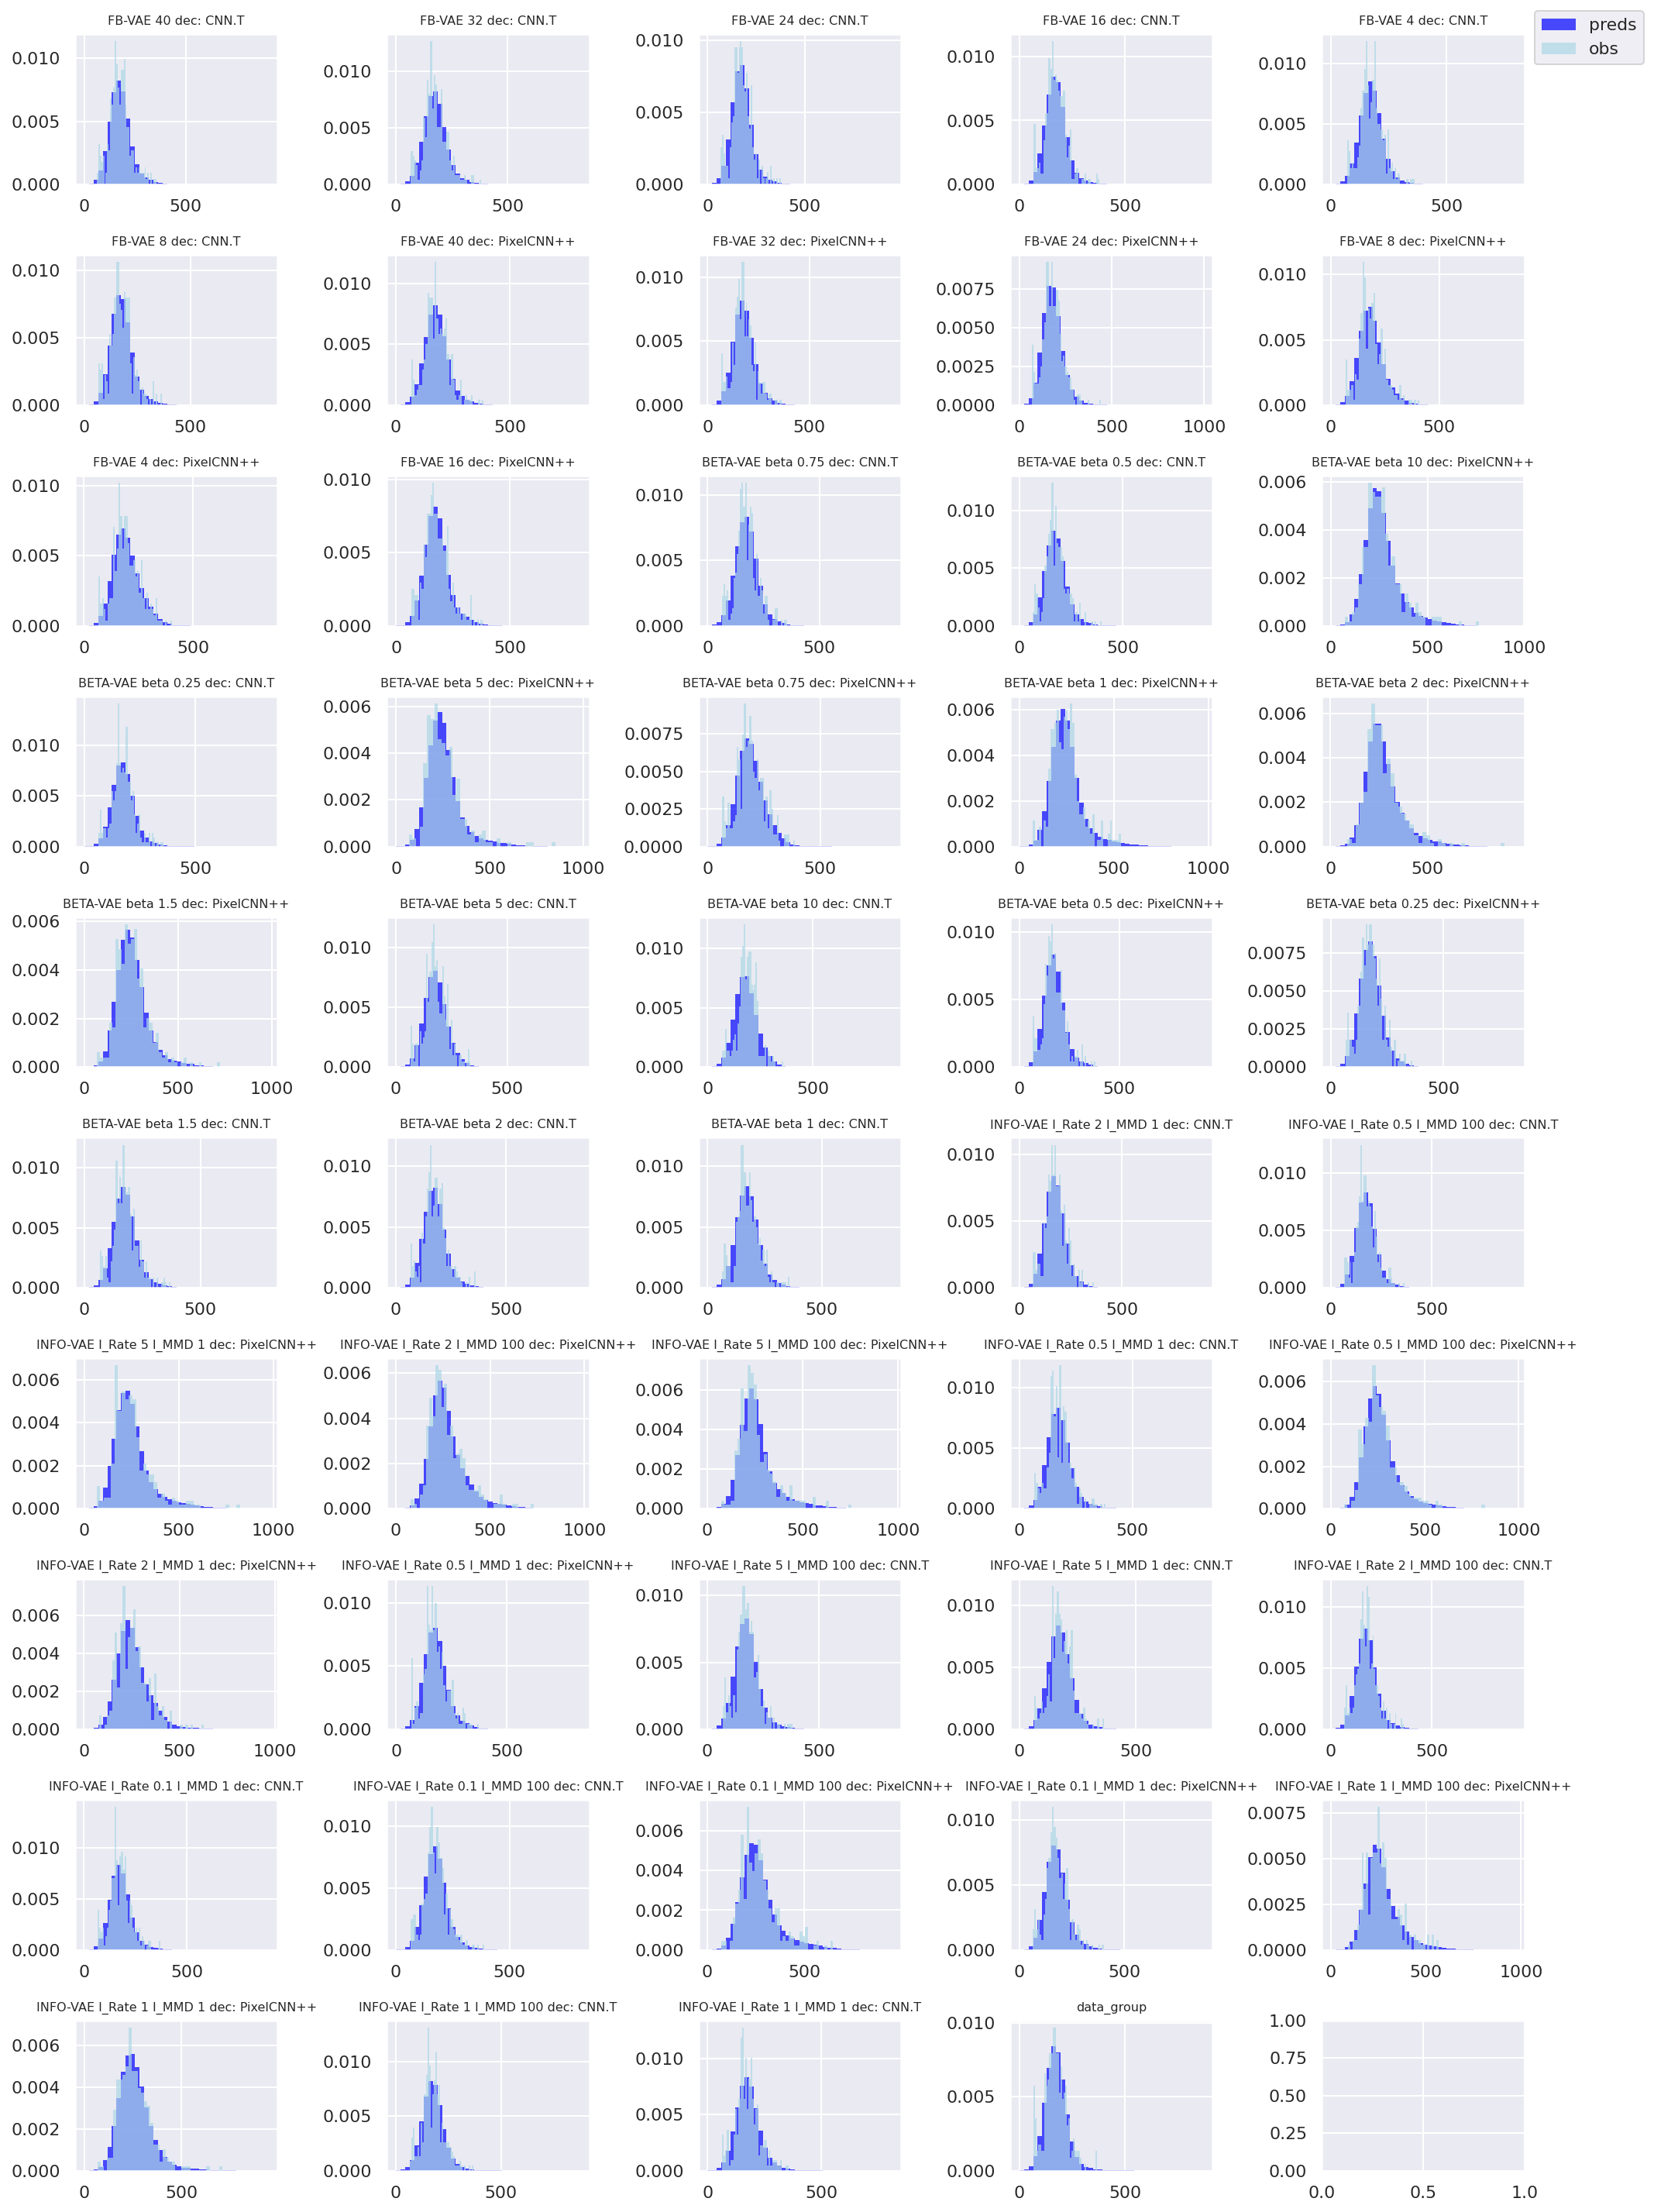

----------------------------------------


In [23]:
RECOMPUTE = False  # <-- set to False if you want to load from pickle

PERFORM_PRIOR_CHECKS = True
PERFORM_POSTERIOR_CHECKS = True

DP_ALPHA = 1.0
OBS_DIST = "truncated_normal"
TRUNCATED_LOW = 0.0

MAX_GROUPS = 100 # all
MAX_PLOT_CHECK = 1

if RECOMPUTE:
    mnist_dp_mixtures = dict()
    
    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:
        print(stat_name)
        
        if stat_name in mnist_dp_mixtures:
            print("Did this one already, continuing..")
            continue

        group_names = []
        observations = []
        
        c = 0
        for i, (k, v) in enumerate(mnist_surprisal_values.items()):
            group_names.append(k)
            observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

            c += 1
            if c == MAX_GROUPS:
                break
                
        if "data_group" not in group_names:
            group_names.append("data_group")
            observations.append(np.array(mnist_surprisal_values["data_group"][stat_name][:MAX_SAMPLES_PER_GROUP]))
            
        print("Number of groups", len(observations))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist=OBS_DIST,
            truncated_normal_low=TRUNCATED_LOW,
            DP_alpha=DP_ALPHA, 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )
    
        if PERFORM_PRIOR_CHECKS:
            print("-"*40)
            print("PRIOR PREDICTIVE PLOTS")
            prior_samples = dp_mixture.draw_prior_predictions(num_samples=400)
            
            print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
            
            surprisal_dp_plot_checks(dp_mixture, prior_samples["y"], plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=True, num_prior_samples=400, filter_vals_higher=1e3)
                
            print("-"*40)
            
        dp_mixture.run()

        mnist_dp_mixtures[stat_name] = dp_mixture
        
        if PERFORM_POSTERIOR_CHECKS:
            print("-"*40)
            print("POSTERIOR PREDICTIVE PLOTS")
            
            posterior_samples = dp_mixture.draw_posterior_predictions()
            samples = posterior_samples["y"]
            
            surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
            plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
            plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3)
            print("-"*40)
    
        pickle.dump(mnist_dp_mixtures, open(MNIST_SAVE_SURPRISAL_DP_FILE, "wb"))
    
else:
    if os.path.exists(MNIST_SAVE_SURPRISAL_DP_FILE):
        
        mnist_dp_mixtures = pickle.load(open(MNIST_SAVE_SURPRISAL_DP_FILE, "rb"))
        
        for stat_name, dp_mixture in mnist_dp_mixtures.items():
            print("STAT:", stat_name)
            if PERFORM_POSTERIOR_CHECKS:
                print("-"*40)
                print("POSTERIOR PREDICTIVE PLOTS")

                posterior_samples = dp_mixture.draw_posterior_predictions()
                samples = posterior_samples["y"]

                surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=MAX_PLOT_CHECK, filter_vals_higher=1e3)
                plot_model_data_preds_obs(dp_mixture, prior=False, filter_vals_higher=1e3)
                plot_all_groups_preds_obs(dp_mixture, prior=False, num_prior_samples=400, filter_vals_higher=1e3, sharex=False, sharey=False)
                print("-"*40)
    else:
        print(f"No DPs saved in MNIST_SAVE_SURPRISAL_DP_FILE={MNIST_SAVE_SURPRISAL_DP_FILE}, set RECOMPUTE=True to re-run.")
        